# COMP9418 Assignment2<br><br>
student:<br>
    z5192086, Pan Luo<br>
    z5181142, Zhidong Luo<br>
    z5190380, Jiawei Ren<br>


# Task 1  Representation

In [1]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# ordered dictionaries are useful for keeping ordered sets of variables
from collections import OrderedDict as odict
# table formating for screen output
from tabulate import tabulate
from copy import deepcopy
from itertools import compress, combinations, product
from collections import defaultdict, Counter, deque
from collections import OrderedDict as odict
import numpy as np
import pandas as pd
from graphviz import Digraph, Graph
import math
import random
import sys
import copy

In [2]:
# tute6
tute_factor = {
    'H': {
        'dom': ('H'), 
        'table': odict([
            ((0,), 0.80),
            ((1,), 0.20),
        ])
    },
    
    'V': {
        'dom': ('L', 'H', 'V'), 
        'table': odict([
            ((0, 0, 0), 0.05),
            ((0, 0, 1), 0.95),
            ((0, 1, 0), 0.99),
            ((0, 1, 1), 0.01),
            ((1, 0, 0), 0),
            ((1, 0, 1), 1),
            ((1, 1, 0), 1),
            ((1, 1, 1), 0),
        ])
    },

    'C' : {
        'dom': ('V', 'C'), 
        'table': odict([
            ((0, 0), 0.94),
            ((0, 1), 0.04),
            ((0, 2), 0.02),
            ((1, 0), 0.02),
            ((1, 1), 0.26),
            ((1, 2), 0.72),
        ])
    },

    'L' : {
        'dom': ('L'), 
        'table': odict([
            ((0, ), 0.95),
            ((1, ), 0.05),
        ])
    },

    'S' : {
        'dom': ('L', 'H', 'S'), 
        'table': odict([
            ((0, 0, 0), 0.04),
            ((0, 0, 1), 0.96),
            ((0, 1, 0), 0.48),
            ((0, 1, 1), 0.52),
            ((1, 0, 0), 0.95),
            ((1, 0, 1), 0.05),
            ((1, 1, 0), 0),
            ((1, 1, 1), 1),
        ])
    },

    'O' : {
        'dom': ('S', 'V', 'O'), 
        'table': odict([
            ((0, 0, 0), 0.97),
            ((0, 0, 1), 0.01),
            ((0, 0, 2), 0.02),
            ((0, 1, 0), 0.78),
            ((0, 1, 1), 0.19),
            ((0, 1, 2), 0.03),
            ((1, 0, 0), 0.22),
            ((1, 0, 1), 0.76),
            ((1, 0, 2), 0.02),
            ((1, 1, 0), 0.01),
            ((1, 1, 1), 0.01),
            ((1, 1, 2), 0.98),        
        ])
    },

    'T': {
        'dom': ('A', 'T'), 
        'table': odict([
            ((0, 0), 0.30),
            ((0, 1), 0.70),
            ((1, 0), 1),
            ((1, 1), 0),
        ])
    },

    'B' : {
        'dom': ('O', 'T', 'B'), 
        'table': odict([
            ((0, 0, 0), 1),
            ((0, 0, 1), 0),
            ((0, 0, 2), 0),
            ((0, 1, 0), 0.30),
            ((0, 1, 1), 0.62),
            ((0, 1, 2), 0.08),
            ((1, 0, 0), 0.93),
            ((1, 0, 1), 0.07),
            ((1, 0, 2), 0),
            ((1, 1, 0), 0.02),
            ((1, 1, 1), 0.49),
            ((1, 1, 2), 0.49),
            ((2, 0, 0), 0.90),
            ((2, 0, 1), 0.08),
            ((2, 0, 2), 0.02),
            ((2, 1, 0), 0.01),
            ((2, 1, 1), 0.08),
            ((2, 1, 2), 0.91),        
        ])
    },

    'A' : {
        'dom': ('A'), 
        'table': odict([
            ((0, ), 0.99),
            ((1, ), 0.01),
        ])
    }
}
tute_os = dict(
    H=(0,1),
    L=(0,1),
    A=(0,1),
    V=(0,1),
    S=(0,1),
    T=(0,1),
    C=(0,1,2),
    O=(0,1,2),
    B=(0,1,2),
)

In [3]:
def printFactor(f):
    """
    argument 
    `f`, a factor to print on screen
    """
    # Create a empty list that we will fill in with the probability table entries
    table = list()
    
    # Iterate over all keys and probability values in the table
    for key, item in f['table'].items():
        # Convert the tuple to a list to be able to manipulate it
        k = list(key)
        # Append the probability value to the list with key values
        k.append(item)
        # Append an entire row to the table
        table.append(k)
    # dom is used as table header. We need it converted to list
    dom = list(f['dom'])
    # Append a 'Pr' to indicate the probabity column
    dom.append('Pr')
    print(tabulate(table,headers=dom,tablefmt='orgtbl'))


def evidence(var, e, outcomeSpace):
    """
    argument 
    `var`, a valid variable identifier.
    `e`, the observed value for var.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns dictionary with a copy of outcomeSpace with var = e
    """    
    newOutcomeSpace = outcomeSpace.copy()      # Make a copy of outcomeSpace with a copy to method copy(). 1 line
    newOutcomeSpace[var] = (e,)                # Replace the domain of variable var with a tuple with a single element e. 1 line
    return newOutcomeSpace
    
def join(f1, f2, outcomeSpace):
    """
    argument 
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor with a join of f1 and f2
    """
    
    # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
    # But it is important to eliminate the repetitions
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))
    
    # We will build a table from scratch, starting with an empty list. Later on, we will transform the list into a odict
    table = list()
    
    # Here is where the magic happens. The product iterator will generate all combinations of varible values 
    # as specified in outcomeSpace. Therefore, it will naturally respect observed values
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        
        # We need to map the entries to the domain of the factors f1 and f2
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])
        
        # Insert your code here
        p1 = prob(f1, *f1_entry)           # Use the fuction prob to calculate the probability in factor f1 for entry f1_entry 
        p2 = prob(f2, *f2_entry)           # Use the fuction prob to calculate the probability in factor f2 for entry f2_entry 
        
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, p1 * p2))
    return {'dom': tuple(common_vars), 'table': odict(table)}


def normalize(f):
    table = list()
    sum = 0
    for k, p in f['table'].items():
        sum = sum + p
    for k, p in f['table'].items():
        table.append((k, p/sum))
    return {'dom': f['dom'], 'table': odict(table)}

def prob(factor, *entry):
    return factor['table'][entry]

def marginalize(f, var, outcomeSpace):
    # Let's make a copy of f domain and convert it to a list. We need a list to be able to modify its elements
    new_dom = list(f['dom'])
    new_dom.remove(var)            # Remove var from the list new_dom by calling the method remove(). 1 line
    table = list()                 # Create an empty list for table. We will fill in table from scratch. 1 line
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        s = 0;                     # Initialize the summation variable s. 1 line
        # We need to iterate over all possible outcomes of the variable var
        for val in outcomeSpace[var]:
            # To modify the tuple entries, we will need to convert it to a list
            entriesList = list(entries)
            # We need to insert the value of var in the right position in entriesList
            entriesList.insert(f['dom'].index(var), val)
            p = prob(f, *tuple(entriesList))     # Calculate the probability of factor f for entriesList. 1 line
            s = s + p                            # Sum over all values of var by accumulating the sum in s. 1 line            
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, s))
    return {'dom': tuple(new_dom), 'table': odict(table)}
   




## 1.1  Insert and remove nodes.

In [4]:
#1.insert nodes
def insert_nodes(factor, outcomespace, newNode, node_os):
    """
    argument 
    `factor`, factor dictionary.
    `outcomeSpace`, dictionary with the domain of each variable.
    `newNode`, insered node name.
    `node_os`, possible value for new node
    
    Returns a new factor and a new outcomespace
    """
    f = deepcopy(factor)
    os = deepcopy(outcomespace)
    os[newNode] = node_os
    f[newNode] = dict()
    f[newNode]['dom'] = tuple([newNode])
    # init all probability as 0
    f[newNode]['table'] = odict.fromkeys(product(*[os[n] for n in list(f[newNode]['dom'])]), 0)
    return f, os
# test for insert node
# insert_nodes(tute_factor,tute_os,'D',(0,1))
# expected outpput
# 'D': {'dom': ('D',), 'table': OrderedDict([((0,), 0), ((1,), 0)])}}

#2.remove nodes
def remove_nodes(factor, outcomespace, node):
    """
    argument 
    `factor`, factor dictionary.
    `outcomeSpace`, dictionary with the domain of each variable.
    'node`, node name to be deleted.
    
    Returns a new factor and a new outcomespace
    """
    f = deepcopy(factor)
    os = deepcopy(outcomespace)
    # disconnect all edges
    for key in f.keys():
        if key != node:
            f, os = disconnect_nodes(f, os, key, node)
    # deleted node
    f.pop(node)
    os.pop(node)
    return f, os            
# test for remove node
# remove_nodes(tute_factor,tute_os,'V')
# output will return the new factor and outcomespace without 'V'

## 1.2  Connect and disconnect nodes with edges.

In [5]:
#3.Connect nodes with edges.
def connect_nodes(factor, outcomespace, node_a, node_b):
    """
    argument 
    `factor`, factor dictionary.
    `outcomeSpace`, dictionary with the domain of each variable.
    `node_a`, source node name.
    `node_b`, destination node name
    
    Returns a new factor and a new outcomespace
    """
    f = deepcopy(factor)
    os = deepcopy(outcomespace)
    # check not connected before connect
    if node_a == node_b:
        return f, os
    elif node_a in f[node_b]['dom']:
        return f, os
    else:
        pass
    firstnode = None
    p = None
    # join all nodes and get the joint distributino prob
    for node in os.keys():
        if firstnode is None:
            firstnode = node
            p = f[firstnode]
        else:
            p = join(p, f[node], os)
    p = normalize(p)
    # marginalise and get P(..., b)
    ll = list(f[node_b]['dom']) + [node_a]
    for node in os.keys():
        if node not in ll:
            p = marginalize(p, node, os)
    
    # marginalise b and get P(....)
    p_x = marginalize(p, node_b, os)

    # compute P(... | b) = P(..., b) / P(...)
    for k in p_x['table']:
        i = p_x['table'][k]
        if p_x['table'][k] != 0:
            p_x['table'][k] = 1 / p_x['table'][k]
    p = join(p, p_x, os)
#     printFactor(p)
    f[node_b] = p
    return f, os
# test for connect node   
# connect_nodes(tute_factor, tute_os, 'V', 'T')
#  output will return the new factor and outcomespace with 'V' in 'T''s dom

In [6]:
#4.Disconnect nodes with edges.

def disconnect_nodes(factor, outcomespace, node_a, node_b):
    """
    argument 
    `factor`, factor dictionary.
    `outcomeSpace`, dictionary with the domain of each variable.
    `node_a`, first node
    `node_b`, second node
    
    Returns a new factor and a new outcomespace
    """
    f = deepcopy(factor)
    os = deepcopy(outcomespace)
    # check
    if node_a == node_b:
        return f, os
    elif node_a in f[node_b]['dom']:
        pass
    # swap order
    elif node_b in f[node_a]['dom']:
        node_a, node_b = node_b, node_a
    else:
        return f, os
    
    # a in b. b->a P(b | ... - a) = P(..., b) / P(....)
    
    # step1 get p_join
    # step1.5 normalise
    # step2 marginalise (all except b, ...)
    # step3 marginalise (b)
    
    # join and get the joint distribution prob
    firstnode = None
    p = None
    for node in os.keys():
        if firstnode is None:
            firstnode = node
            p = f[firstnode]
        else:
            p = join(p, f[node], os)
    p = normalize(p)
    # marginalise and get P(..., a, b)
    for node in os.keys():
        if node not in f[node_b]['dom']:
            p = marginalize(p, node, os)
    # marginalise a and get P(..., b)
    p = marginalize(p, node_a, os)
    # marginalise b and get P(....)
    p_x = marginalize(p, node_b, os)
    # compute P(...|b)
    for k in p_x['table']:
        i = p_x['table'][k]
        if p_x['table'][k] != 0:
            p_x['table'][k] = 1 / p_x['table'][k]
    p = join(p, p_x, os)
#     printFactor(p)
    f[node_b] = p
    return f, os
    
# test for disconnect node 
# disconnect_nodes(tute_factor, tute_os, 'T', 'B')
# output will return the new factor and outcomespace with 'T' not in 'B''s dom

## 1.3  Specify probabilities for a node.

In [7]:
# 5.Specify probabilities for a node.
def set_probability(factor, node, prob_dict):
    """
    argument 
    `factor`, factor dictionary.
    `node`, node name
    `prob_dict`, a dictionary storing all prob
    
    Returns a new factor
    """
    f = deepcopy(factor)
    for key, prob in prob_dict.items():
        f[node]['table'][key]  = prob
    return f
# test for this part
# set_probability(tute_factor,'A',odict([((0, ), 0.69),((1, ), 0.31)]))
#expected output
# 'A': {'dom': 'A', 'table': OrderedDict([((0,), 0.69), ((1,), 0.31)])

## 1.4 Save Bayesian network to a file.

In [8]:
#6. Save Bayesian network to a file.
def save_to_file(factor, outcomespace ,file):
    """
    argument 
    `factor`, factor dictionary.
    `outcomeSpace`, dictionary with the domain of each variable.
    `file`, file name.
    
    """
    with open(file ,"w") as f:
        # header
        print('net\n{\n}', file = f)
        # write nodes in the file 
        for node in outcomespace.keys():
            os = list(outcomespace[node])
            os = [f'"{o}"' for o in os]
            os = ' '.join(os)
            print(os)
            print(f'node {node}\n{{\n  states = ( {os} );\n}}', file = f)
        # write probability in the file
        for node in factor:
            if len(factor[node]['dom']) == 1:
                data = list(factor[node]["table"].values())
                data = ' '.join([str(d) for d in data])
                print(f'potential ( {node} )\n{{\n  data = ( {data} );\n}}', file = f)

            else:
                parent = list(factor[node]["dom"][:-1])
                parent = ' '.join(parent)
                data = list(factor[node]["table"].values())
                data = [str(d) for d in data]
                flag = 0
                for n in factor[node]["dom"][-1::-1]:
                    group_nb = len(data) // len(outcomespace[n])
                    nb_of_group = len(outcomespace[n])
    
                    data = [data[nb_of_group * i: nb_of_group *  i + nb_of_group] for i in range(group_nb)]
                    if flag == 0:
                        data = [f'({" ".join(i)})' for i in data]
                        flag = 1
                    else:
                        data = [f'({"".join(i)})' for i in data]
                print(f'potential ( {node} | {parent} )\n{{\n  data = {data[0]} ;\n}}', file = f)
#test code 
# save_to_file(tute_factor, tute_os ,'factor.net')                                                                        

## 1.5 Load Bayesian network from a file.

In [9]:
#7.Load Bayesian network from a file.
def load_from_file(file):
    """
    argument 
    `file`, input file name.
    
    Return a new factor and a new outcomespace
    """
    with open(file ,"r") as f:
        node = None
        state = None
        os = dict()
        factor = {}
        for i in f:
            line = i.strip()
            if line.startswith('net') or line.startswith('{') or line.startswith('}'):
                pass
            # get node name
            elif line.startswith('node'):
                node = line.split()[1].strip()
                factor[node] = dict()
            # get os
            elif line.startswith('states'):
                state_info = line[line.index('(') + 1: line.index(')')]
                state_info = state_info.replace('"', '').replace("'", '')
                state = tuple(state_info.split())
                os[node] = state
            # get relationship
            elif line.startswith('potential'):
                info = line[line.index('(') + 1: line.index(')')]
                # conditional
                if '|' in info :
                    node = info.split('|')[0].strip()
                    parent = info.split('|')[1].split()
                    factor[node]['dom'] = tuple(parent + [node])
                else:
                    node = info.strip()
                    factor[node]['dom'] = tuple([node])
            # get prob
            elif line.startswith('data'):
                info = line[line.index('(') + 1: line.rindex(')')]
                info_list = info.replace('(', ' ').replace(')', ' ').split()
                it = iter(info_list)
                factor[node]['table'] = odict.fromkeys(product(*[os[n] for n in list(factor[node]['dom'])]), 0)
                for key in factor[node]['table'].keys():
                    factor[node]['table'][key] = float(next(it))
            else:
                pass
    return factor, os
# test code
# load_from_file('factor.net')

# Benchmark

Here is our benchmark for task 1, we only test for loading some large network files to bayesian network and check the running time. Further analysis will be shown in the report.

In [10]:
#medium network with 37 nodes and 509 parameters
%time f,s=load_from_file('alarm.net')

Wall time: 1 ms


In [11]:
#large network with 70 nodes and 1453 parameters
%time f,s=load_from_file('hepar2.net')

Wall time: 3.03 ms


In [12]:
#very large network with 1051 nodes and 80592 parameters
%time f,s=load_from_file('munin.net')

Wall time: 83 ms


In [13]:
small_factor, small_os = load_from_file('asia.net')

In [14]:
medium_factor, medium_os = load_from_file('child.net')

In [15]:
large_factor, large_os = load_from_file('hailfinder.net')

In [16]:
verylarge_factor, verylarge_os = load_from_file('pathfinder.net')

In [17]:
massive_factor, massive_os = load_from_file('munin.net')

# Task 2  Pruning and pre-processing techniques for inference

In [18]:
# prepocessing for task 2
# convert factor to directed graph
def factor_to_graph(f):
    """
    argument 
    `factor`, factor dictionary.
    
    Return the directed grpah of f
    """
    g = defaultdict(list)
    for k in f.keys():
        for n in list(f[k]['dom']):
            if n == k:
                continue
            g[n].append(k)
    return g
    
# change outcomespace to 0 1
def ttransform(f, os):
    ff = deepcopy(f)
    o = deepcopy(os)
    d = dict()
    for k, v in os.items():
        #v
        d[k] = dict(zip(v, range(len(v))))
        o[k] = tuple(list(range(len(v))))
    
    for k, v in f.items():
        ff[k] = dict()
        ff[k]['dom'] = f[k]['dom']
        ff[k]['table'] = odict()
        
        for kk, vv in f[k]['table'].items():
            it = iter(list(f[k]['dom']))
            l = []
            for i in kk:
                node = next(it)
                l.append(d[node][i])
            l = tuple(l)
            ff[k]['table'][l] = vv

    return ff, o
# printFactor(w_prob)

In [19]:

sample_graph = {
    'A': ['B', 'C'],
    'B': ['D'],
    'C': ['D', 'E'],

}

sample_factors = {
    'A': {
        'dom': ('A'), 
        'table': odict([
            ((0,), 0.40),
            ((1,), 0.60),
        ])
    },
    
    'B': {
        'dom': ('A', 'B'), 
        'table': odict([
            ((0, 0), 0.25),
            ((0, 1), 0.75),
            ((1, 0), 0.80),
            ((1, 1), 0.20),
        ])
    },

    'C' : {
        'dom': ('A', 'C'), 
        'table': odict([
            ((0, 0), 0.90),
            ((0, 1), 0.10),
            ((1, 0), 0.20),
            ((1, 1), 0.80),
        ])
    },

    'D' : {
        'dom': ('B', 'C', 'D'), 
        'table': odict([
            ((0, 0, 0), 1.00),
            ((0, 0, 1), 0.00),
            ((0, 1, 0), 0.20),
            ((0, 1, 1), 0.80),
            ((1, 0, 0), 0.10),
            ((1, 0, 1), 0.90),
            ((1, 1, 0), 0.05),
            ((1, 1, 1), 0.95),
            
        ])
    },

    'E' : {
        'dom': ('C', 'E'), 
        'table': odict([
            ((0, 0), 1.00),
            ((0, 1), 0.00),
            ((1, 0), 0.30),
            ((1, 1), 0.70),
        ])
    },

}

sample_outcomeSpace = dict(
    A=(0,1),
    B=(0,1),
    C=(0,1),
    D=(0,1),
    E=(0,1)
)

## 2.1 Network pruning techniques based on query structure.

Similar to assignment 1, we use a numpy to represent the graph in adjacent matrix format. When removing a node, we delete the corresponding information in the factor. When removing an edge, we marginalise the corresponding information in the factor

In [20]:
# recursion function for removing leaf node
def remove_leaf_r(matrix, l, union_set, F):
    """
    argument 
    `matrix`, adjacent matrix for a graph
    `l`, order list
    `union_set`, a set containing nodes cannot be removed
    `F`, factor
    
    Return matrix after removing all leaf nodes
    """
    # get the number of outgoing edges
    line_sum = np.sum(matrix, axis = 1)
    # get the index of leaf nodes
    bool_list = np.equal(line_sum, 0)
    index_list = [*compress(range(matrix.shape[0]), bool_list)]
    # we cannot delete leaf node which belongs to X ∪ Y ∪ Z
    deleted_list = []
    copied_list = index_list.copy()
    for i in copied_list:
        if l[i] in union_set:
            index_list.remove(i)
        else:
            deleted_list.append(l[i])
    # when we have leaf node to delete
    if len(deleted_list) > 0:
        # delete that leaf node. In numpy matrix, we delete the corresponding row and column
        matrix = np.delete(matrix, index_list, axis = 0)
        matrix = np.delete(matrix, index_list, axis = 1)
        # update the nodes list
        for i in deleted_list:
            l.remove(i)
            # remove node from factor
            del F[i]
        # recursively delete leaf nodes from the newly created graph
        matrix = remove_leaf_r(matrix, l, union_set, F)
    return matrix
    
# time comlexity: O(n + e)    
def prune(G, F, outcomeSpace, Q, E):
    """
    argument 
    `G`, graph dict
    `F`, factor
    `outcomeSpace`, outcomespace dict
    `Q`, query variable
    `E`, evidence dict
    
    """
    FF = deepcopy(F)
    # get the union set of Q ∪ E
    union_set = set(Q) | set(E.keys())
    # get all nodes name
    nodes = (set(G.keys()) | set(node for children in G.values() for node in children))
    # sort nodes name
    order_node_list = sorted(nodes)
    # represent graph in a adjacent matrix using numpy
    matrix = np.zeros((len(nodes), len(nodes)), dtype = int)
    for key, values in G.items():
        for value in values:
            matrix[order_node_list.index(key), order_node_list.index(value)] = 1
    # recursively remove leaf nodes
    matrix = remove_leaf_r(matrix, order_node_list, union_set, FF)
    # delete outgoing edges from Z
    o = deepcopy(outcomeSpace)
    for i in E.keys():
        delete_edge_index = np.where(matrix[order_node_list.index(i)] > 0)
        matrix[order_node_list.index(i), delete_edge_index] = 0
        # marginalise to get the new prob
        for index in delete_edge_index[0]:
            node = order_node_list[index]
            o = evidence(i, E[i], o)
            FF[node] = marginalize(FF[node], i, o)
            
    # represent graph in a adjacent list format using python dictionary
    G = dict()
    for i in order_node_list:
        G[i] = []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if matrix[i, j] > 0:
                G[order_node_list[i]].append(order_node_list[j])
    return G, FF, o

##############################
# Test code
##############################
graph1, F, o = prune(sample_graph, sample_factors, sample_outcomeSpace, {'D', 'E'}, {'A' : 1, 'C' : 0})




Draw the graph after pruning.

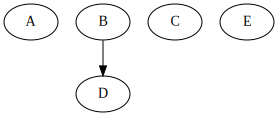

In [21]:
# graphT = transposeGraph(graph)

dot = Digraph(comment='Direct transpose graph GT')

for v in graph1:
    dot.node(str(v))

for v in graph1:
    for w in graph1[v]:
        dot.edge(str(v), str(w))
dot

## 2.2 Min-fill heuristic for variable order elimination.

In [22]:
# tutorial minDegree
def minDegree(ig):
    """
    argument 
    `ig`, an induced graph,
    Returns a elimination order according to the min-degree heuristic
    """      
    # Initialize order with empty list. This variable will have the answer in the end of the execution
    order = []
    # While the induced graph has nodes to be eliminated
    while ig:
        # Initialize minDegree with a large number: math.inf
        minDegree = math.inf
        for var in ig.keys():
            # Test if var has a degree smaller than minDegree
            if len(ig[var]) < minDegree:
                # We have found a new candidate to be the next eliminated variable. Let's save its degree and name
                minDegree = len(ig[var])
                minVar = var
        # Insert in order the variable in minVar
        order.append(minVar)
        # Now, we need to remove minVar from the adjacency list of every node
        for var in ig.keys():
            if minVar in ig[var]:
                ig[var].remove(minVar)
        # As well as remove minVar adjacency list from the graph
        del ig[minVar]
    return order

####################
# Test code
# minDegree(induceGraph(sample_factors, sample_outcomeSpace))

we finished minFill and Deterministic and stochastic composition of minFill and minDegree.<br>Specifically, minFill function is the simple minFill. minFill_then_minDegree function uses minFill firstly and uses minDegree to break ties. minDegree_then_minFill funtion uses minDegree firstly and uses minFill to break ties. stochastic_minDegree_and_minFill function uses a random number to decide to check minFill or minDegree firstly.

In [23]:

def transposeGraph(G):
    """
    argument 
    `G`, a directed graph,
    
    Returns a transposed graph of G
    """      
    GT = dict((v, []) for v in G)
    for v in G:
        for w in G[v]:
            if w in GT:
                GT[w].append(v)
            else:
                GT[w] = [v]
    return GT
#convert directed graph to undi graph
def moralise(G):
    """
    argument 
    `G`, a directed graph,
    
    Returns a moralised graph of G
    """
    GT = transposeGraph(G)
    MG = deepcopy(G)
    for v in G:
        for w in G[v]:
            if w not in MG:
                MG[w] = []
            if v not in MG[w]:
                MG[w].append(v)
                
    for v in GT:
        if len(GT[v]) > 1:
            for a, b in combinations(GT[v], 2):
                if a not in MG[b]:
                    MG[b].append(a)
                    MG[a].append(b)
    return MG
    
    
    
    
def minFill(g):
    """
    argument 
    `g`, an directed graph,
    Returns a elimination order according to the min-fill heuristic
    """      
    # Initialize order with empty list.
    order = []
    # moralise
    mg = moralise(g)
    v_list = [node for node in mg.keys()]
    v_list.sort()
    while mg:
        minFill = math.inf
        for var in v_list:
            # compute fill-in node number
            fill = 0
            for a, b in combinations(mg[var], 2):
                if a not in mg[b]:
                    fill += 1
            # get min fill-in node number
            if fill < minFill:
                minFill = fill
                minVar = var
        order.append(minVar)
        # fill in
        for a, b in combinations(mg[minVar], 2):
            if a not in mg[b]:
                mg[b].append(a)
                mg[a].append(b)
        # remove node we chose
        for var in mg.keys():
            if minVar in mg[var]:
                mg[var].remove(minVar)
        del mg[minVar]
        v_list.remove(minVar)
    return order

def minFill_then_minDegree(g):
    """
    argument 
    `g`, an directed graph,
    Returns a elimination order according to the minFill_then_minDegree heuristic
    """    
    # Initialize order with empty list.
    order = []
    mg = moralise(g)
    v_list = [node for node in mg.keys()]
    v_list.sort()
    while mg:
        minFill = math.inf
        candidate = []
        for var in v_list:
            # compute fill-in node number
            fill = 0
            for a, b in combinations(mg[var], 2):
                if a not in mg[b]:
                    fill += 1
            if fill < minFill:
                minFill = fill
                minVar = var
                candidate = [minVar]
            elif fill == minFill:
                candidate.append(var)
        # if we have multiple choice
        if len(candidate) > 1:
            # start minDegree
            minDegree = math.inf
            for var in candidate:
                if len(mg[var]) < minDegree:
                    minDegree = len(mg[var])
                    minVar = var
        order.append(minVar)
        # fill in
        for a, b in combinations(mg[minVar], 2):
            if a not in mg[b]:
                mg[b].append(a)
                mg[a].append(b)
        # remove the node we chose
        for var in mg.keys():
            if minVar in mg[var]:
                mg[var].remove(minVar)
        del mg[minVar]
        v_list.remove(minVar)
    return order

def minDegree_then_minFill(g):
    """
    argument 
    `g`, an directed graph,
    Returns a elimination order according to the minDegree_then_minFill heuristic
    """       
    # Initialize order with empty list.
    order = []
    mg = moralise(g)
    v_list = [node for node in mg.keys()]
    v_list.sort()
    while mg:
        candidate = []
        # start minDegree
        minDegree = math.inf
        for var in v_list:
            if len(mg[var]) < minDegree:
                minDegree = len(mg[var])
                minVar = var
                candidate = [minVar]
            elif len(mg[var]) == minDegree:
                candidate.append(var)
        # if we have multiple choice
        if len(candidate) > 1:
            # start minFill
            minFill = math.inf
            for var in candidate:
                # compute the fill-in node number
                fill = 0
                for a, b in combinations(mg[var], 2):
                    if a not in mg[b]:
                        fill += 1
                if fill < minFill:
                    minFill = fill
                    minVar = var
        order.append(minVar)
        # fill in
        for a, b in combinations(mg[minVar], 2):
            if a not in mg[b]:
                mg[b].append(a)
                mg[a].append(b)
        # remove the node we chose
        for var in mg.keys():
            if minVar in mg[var]:
                mg[var].remove(minVar)
        del mg[minVar]
        v_list.remove(minVar)
    return order

def stochastic_minDegree_and_minFill(g):
    """
    argument 
    `g`, an directed graph,
    Returns a elimination order according to the stochastic_minDegree_and_minFill heuristic
    """            
    # Initialize order with empty list.
    order = []
    mg = moralise(g)
    v_list = [node for node in mg.keys()]
    v_list.sort()
    while mg:
        # start minDegree_then_minFill
        if random.random() > 0.5:
            candidate = []
            minDegree = math.inf
            for var in v_list:
                if len(mg[var]) < minDegree:
                    minDegree = len(mg[var])
                    minVar = var
                    candidate = [minVar]
                elif len(mg[var]) == minDegree:
                    candidate.append(var)
            if len(candidate) > 1:
                minFill = math.inf
                for var in candidate:
                    fill = 0
                    for a, b in combinations(mg[var], 2):
                        if a not in mg[b]:
                            fill += 1
                    if fill < minFill:
                        minFill = fill
                        minVar = var
        # start minFill_then_minDegree
        else:
            minFill = math.inf
            candidate = []
            for var in v_list:
                # var,
                # mg[var]
                fill = 0
                for a, b in combinations(mg[var], 2):
                    if a not in mg[b]:
                        fill += 1
                if fill < minFill:
                    minFill = fill
                    minVar = var
                    candidate = [minVar]
                elif fill == minFill:
                    candidate.append(var)
            if len(candidate) > 1:
                # start minDegree
                minDegree = math.inf
                for var in candidate:
                    if len(mg[var]) < minDegree:
                        minDegree = len(mg[var])
                        minVar = var
        order.append(minVar)
        for a, b in combinations(mg[minVar], 2):
            if a not in mg[b]:
                mg[b].append(a)
                mg[a].append(b)
        for var in mg.keys():
            if minVar in mg[var]:
                mg[var].remove(minVar)
        del mg[minVar]
        v_list.remove(minVar)
    return order


####################
# Test code
# t_graph = {'A': ['B', 'C'], 'B': ['A', 'C', 'D'], 'C': ['A', 'B', 'D', 'E'], 'D': ['B', 'C'], 'E': ['C']}

# mg = moralise(t_graph)
# order = minFill(t_graph)
# print(order)
# order = minFill_then_minDegree(t_graph)
# print(order)
# order = minDegree_then_minFill(t_graph)
# print(order)
# order = stochastic_minDegree_and_minFill(t_graph)
# print(order)

# Benchmark

In [24]:
def induceGraph(factors, outcomeSpace):
    """
    argument 
    `factors`, a dictionary of factors, each factor is a dictionary of domain and probability values,
    `outcomeSpace`, a dictionary with variable names and respective domains.
    Returns an adjacency list representation of the induced graph
    """        
    # Initialize representation that is a dictionary of node ids
    ig = {}
    # Initialize each adjacency list with an empty list
    for var in outcomeSpace.keys():
        ig[var] = []
    for f_id in factors.keys():
        for var1 in factors[f_id]['dom']:
            for var2 in factors[f_id]['dom']:
                if var1 != var2 and var2 not in ig[var1]:
                    # Connect node var1 with var2 by adding var2 in the adjaceny list of var1
                    ig[var1].append(var2)
    return ig

def VE(factors, order, outcomeSpace):
    """
    argument 
    `factors`, a dictionary of factors, each factor is a dictionary of domain and probability values,
    `order`, a list of variable names specifying an elimination order,
    `outcomeSpace`, a dictionary with variable names and respective domains.
    Returns a dictionary with non-eliminated factors
    """    

    # Let's make a copy of factors, so we can freely modify it without distroying the original dictionary
    f = factors.copy()
    # We process the factor in elimination order  
    for i, var in enumerate(order):
        # This is the domain of the new factor. We use sets as it is handy to eliminate duplicate variables
        newFactorDom = set()
        # This is a list of factors that will be removed from f because they were joined with other factors
        listFactorsRemove = list()
        # This is a flag to indicate if we are processing the first factor
        first = True
        # Lets iterate over all factors
        for f_id in f.keys():
            # and select the ones that have the variable to be eliminated
            if var in f[f_id]['dom']:        
                if first:
                    # We need this code since join requires two factors, so we save the first one in fx and wait for the next
                    fx = f[f_id]
                    first = False
                else:
                    # Join fx and f[f_id] and save the result in fx
                    fx = join(fx, f[f_id], outcomeSpace)
                # f_id was joined, so we will need to eliminate it from f later. Let's save that factor id for future removal
                listFactorsRemove.append(f_id)
        # Now, we need to remove var from the domain of the new factor doing a marginalization              
        fx = marginalize(fx, var, outcomeSpace)
        # Now, we remove all factors that we joined in the simulation. We do it outside the for loop since it modifies the data structure
        for f_id in listFactorsRemove:
            del f[f_id]
        # We will create a new factor with id equal a sequential number and insert it into f, so it can be used in future joins          
        f[i] = fx
    return f

In [25]:
def join(f1, f2, outcomeSpace):
    """
    argument 
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor with a join of f1 and f2
    """
    
    #########################
    # Insert your code here #
    #########################
    global muls

    # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
    # But it is important to eliminate the repetitions
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))
    
    # We will build a table from scratch, starting with an empty list. Later on, we will transform the list into a odict
    table = list()
    
    # Here is where the magic happens. The product iterator will generate all combinations of varible values 
    # as specified in outcomeSpace. Therefore, it will naturally respect observed values
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        
        # We need to map the entries to the domain of the factors f1 and f2
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])
        
        # Insert your code here
        p1 = prob(f1, *f1_entry)           # Use the fuction prob to calculate the probability in factor f1 for entry f1_entry 
        p2 = prob(f2, *f2_entry)           # Use the fuction prob to calculate the probability in factor f2 for entry f2_entry 
        
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, p1 * p2))
        
        #########################
        # Insert your code here #
        #########################
        muls = muls + 1
    return {'dom': tuple(common_vars), 'table': odict(table)}



def marginalize(f, var, outcomeSpace):
    """
    argument 
    `f`, factor to be marginalized.
    `var`, variable to be summed out.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor f' with dom(f') = dom(f) - {var}
    """    

    #########################
    # Insert your code here #
    #########################    
    global adds

    # Let's make a copy of f domain and convert it to a list. We need a list to be able to modify its elements
    new_dom = list(f['dom'])
    new_dom.remove(var)            # Remove var from the list new_dom by calling the method remove(). 1 line
    table = list()                 # Create an empty list for table. We will fill in table from scratch. 1 line
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        s = 0;                     # Initialize the summation variable s. 1 line

        # We need to iterate over all possible outcomes of the variable var
        for val in outcomeSpace[var]:
            # To modify the tuple entries, we will need to convert it to a list
            entriesList = list(entries)
            # We need to insert the value of var in the right position in entriesList
            entriesList.insert(f['dom'].index(var), val)
            
            p = prob(f, *tuple(entriesList))     # Calculate the probability of factor f for entriesList. 1 line
            s = s + p                            # Sum over all values of var by accumulating the sum in s. 1 line
            
            #########################
            # Insert your code here #
            #########################
            adds = adds + 1
            
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, s))
    return {'dom': tuple(new_dom), 'table': odict(table)}

Following is our benchmark on testing the difference of add and multiply times on different algorithm. We use min_Degree as comparison with our algorithm implmented in task2.2. Besides, we will do the test on different dataset.

In [26]:
# small dataset
adds = 0
muls = 0
%time VE(small_factor, minDegree(factor_to_graph(small_factor)), small_os)
print(adds)
print(muls)
adds = 0
muls = 0
%time VE(small_factor, minDegree_then_minFill(factor_to_graph(small_factor)), small_os)
print(adds)
print(muls)

Wall time: 1e+03 µs
60
64
Wall time: 0 ns
46
38


In [27]:
# medium dataset
adds = 0
muls = 0
%time VE(medium_factor, minDegree(factor_to_graph(medium_factor)), medium_os)
print(adds)
print(muls)
adds = 0
muls = 0
%time VE(medium_factor, minDegree_then_minFill(factor_to_graph(medium_factor)), medium_os)
print(adds)
print(muls)

Wall time: 107 ms
24702
27072
Wall time: 5.04 ms
672
1518


Note that later on we will not use min_degree to make comparison, because we find that min_degree function can not be used for large dataset. We try to use min_degree on 'hailfinder.net' and it last for 10 minutes but the result still not come out. 

In [28]:
# large dataset
# adds = 0
# muls = 0

# %time VE(large_factor, minDegree(factor_to_graph(large_factor)), large_os)
# print(adds)
# print(muls)
adds = 0
muls = 0
%time VE(large_factor, minDegree_then_minFill(factor_to_graph(large_factor)), large_os)
print(adds)
print(muls)


Wall time: 38 ms
11023
11000


In [29]:
# very large dataset
adds = 0
muls = 0
%time VE(verylarge_factor, minDegree_then_minFill(factor_to_graph(verylarge_factor)), verylarge_os)
print(adds)
print(muls)

Wall time: 1 s
205069
259182


In [30]:
# massive dataset
adds = 0
muls = 0
%time VE(massive_factor, minDegree_then_minFill(factor_to_graph(massive_factor)), massive_os)
print(adds)
print(muls)

Wall time: 1min 49s
21533030
24445078


# Task 3  Exact inference


## 3.1  A representation for the jointree that can be specified by the user

We use a dict to store a jointree, the key in this dict is the cluster in each node of jointree and the corresponding valve(s) is/are the neighbor(s). We also use a dict to store the seperator, the key is the union of two clusters, and value is the corresponding seperator between the edge of these two clusters. For task 3.1, we just build two dicts which users can enter the information of node and seperator. But in the later part, the jointree and corresponding seperators will build automatically from an elimination order.

In [31]:
# This function is a helper funtion and used for user input and it is useless in the implementation of other function later. From later 
# on we will generate a jointree and corresponding seperators from an elimination order.

def specify_jointree(tree, S):
#     format of tree:

#     tree=dict(
# #     enter the node and neighbors here, for example    
# #     L= ('S'),
# #     H= ('S'),
    
#     )

#     format of seperator:
    
#     S=dict(
# #     enter the union cluster and corresponding seperator here, for example
# #     LS= ('L'),
# #     HS= ('H'),
              
#     )
    
    return tree,S

# 3.2 A function that converts an elimination order into a jointree

  We use the algorithm in the slides which converts an elimination order to a join tree. First, get all factors from an elimination order. Let's call them clusters. Then delete all the nonmaximum clusters. Then do assembly(add edge between clusters based on some rules). We will introduce each step in the algorithm specifically in the following functions.

In [32]:

# Specify factors of the graph and corresponding outcomespace

icu_factors = {
    'H': {
        'dom': ('H'),
        'table': odict([
            ((0,), 0.80),
            ((1,), 0.20),
        ])
    },

    'V': {
        'dom': ('L', 'H', 'V'),
        'table': odict([
            ((0, 0, 0), 0.05),
            ((0, 0, 1), 0.95),
            ((0, 1, 0), 0.99),
            ((0, 1, 1), 0.01),
            ((1, 0, 0), 0),
            ((1, 0, 1), 1),
            ((1, 1, 0), 1),
            ((1, 1, 1), 0),
        ])
    },

    'C': {
        'dom': ('V', 'C'),
        'table': odict([
            ((0, 0), 0.94),
            ((0, 1), 0.04),
            ((0, 2), 0.02),
            ((1, 0), 0.02),
            ((1, 1), 0.26),
            ((1, 2), 0.72),
        ])
    },

    'L': {
        'dom': ('L'),
        'table': odict([
            ((0,), 0.95),
            ((1,), 0.05),
        ])
    },

    'S': {
        'dom': ('L', 'H', 'S'),
        'table': odict([
            ((0, 0, 0), 0.04),
            ((0, 0, 1), 0.96),
            ((0, 1, 0), 0.48),
            ((0, 1, 1), 0.52),
            ((1, 0, 0), 0.95),
            ((1, 0, 1), 0.05),
            ((1, 1, 0), 0),
            ((1, 1, 1), 1),
        ])
    },

    'O': {
        'dom': ('S', 'V', 'O'),
        'table': odict([
            ((0, 0, 0), 0.97),
            ((0, 0, 1), 0.01),
            ((0, 0, 2), 0.02),
            ((0, 1, 0), 0.78),
            ((0, 1, 1), 0.19),
            ((0, 1, 2), 0.03),
            ((1, 0, 0), 0.22),
            ((1, 0, 1), 0.76),
            ((1, 0, 2), 0.02),
            ((1, 1, 0), 0.01),
            ((1, 1, 1), 0.01),
            ((1, 1, 2), 0.98),
        ])
    },

    'T': {
        'dom': ('A', 'T'),
        'table': odict([
            ((0, 0), 0.30),
            ((0, 1), 0.70),
            ((1, 0), 1),
            ((1, 1), 0),
        ])
    },

    'B': {
        'dom': ('O', 'T', 'B'),
        'table': odict([
            ((0, 0, 0), 1),
            ((0, 0, 1), 0),
            ((0, 0, 2), 0),
            ((0, 1, 0), 0.30),
            ((0, 1, 1), 0.62),
            ((0, 1, 2), 0.08),
            ((1, 0, 0), 0.93),
            ((1, 0, 1), 0.07),
            ((1, 0, 2), 0),
            ((1, 1, 0), 0.02),
            ((1, 1, 1), 0.49),
            ((1, 1, 2), 0.49),
            ((2, 0, 0), 0.90),
            ((2, 0, 1), 0.08),
            ((2, 0, 2), 0.02),
            ((2, 1, 0), 0.01),
            ((2, 1, 1), 0.08),
            ((2, 1, 2), 0.91),
        ])
    },

    'A': {
        'dom': ('A'),
        'table': odict([
            ((0,), 0.99),
            ((1,), 0.01),
        ])
    }
}

outcomeSpace = dict(
    H=(0, 1),
    L=(0, 1),
    A=(0, 1),
    V=(0, 1),
    S=(0, 1),
    T=(0, 1),
    C=(0, 1, 2),
    O=(0, 1, 2),
    B=(0, 1, 2),
)



# A helper function to get all clusters in a jointree from an elimination order. Modifyied from VE function in tutorial.

def ne(factors, order, outcomeSpace):
    """
    argument
    `factors`, a dictionary of factors, each factor is a dictionary of domain and probability values,
    `order`, a list of variable names specifying an elimination order,
    `outcomeSpace`, a dictionary with variable names and respective domains.
    Returns two lists , node and edge
    """
    node = []
    edge = []
    # Let's make a copy of factors, so we can freely modify it without distroying the original dictionary
    f = factors.copy()
    # We process the factor in elimination order
    for i, var in enumerate(order):
        # This is the domain of the new factor. We use sets as it is handy to eliminate duplicate variables
        newFactorDom = set()
        # This is a list of factors that will be removed from f because they were joined with other factors
        listFactorsRemove = list()
        # This is a flag to indicate if we are processing the first factor
        first = True
        # Lets iterate over all factors
        for f_id in f.keys():
            # and select the ones that have the variable to be eliminated
            if var in f[f_id]['dom']:
                if first:
                    # We need this code since join requires two factors, so we save the first one in fx and wait for the next
                    fx = f[f_id]
                    first = False
                else:
                    # Join fx and f[f_id] and save the result in fx
                    fx = join(fx, f[f_id], outcomeSpace)

                # f_id was joined, so we will need to eliminate it from f later. Let's save that factor id for future removal
                listFactorsRemove.append(f_id)
                # print(listFactorsRemove)
        # Now, we need to remove var from the domain of the new factor doing a marginalization
        node.append(fx['dom'])
        fx = marginalize(fx, var, outcomeSpace)
        edge.append(fx['dom'])
        # Now, we remove all factors that we joined in the simulation. We do it outside the for loop since it modifies the data structure
        for f_id in listFactorsRemove:
            del f[f_id]
        # We will create a new factor with id equal a sequential number and insert it into f, so it can be used in future joins
        f[i] = fx

    return node,edge


# Four helper functions which copied from tutorial

def printFactor(f):
    """
    argument
    `f`, a factor to print on screen
    """
    # Create a empty list that we will fill in with the probability table entries
    table = list()

    # Iterate over all keys and probability values in the table
    for key, item in f['table'].items():
        # Convert the tuple to a list to be able to manipulate it
        k = list(key)
        # Append the probability value to the list with key values
        k.append(item)
        # Append an entire row to the table
        table.append(k)
    # dom is used as table header. We need it converted to list
    dom = list(f['dom'])
    # Append a 'Pr' to indicate the probabity column
    dom.append('Pr')
    print(tabulate(table, headers=dom, tablefmt='orgtbl'))




def prob(factor, *entry):
    """
    argument
    `factor`, a dictionary of domain and probability values,
    `entry`, a list of values, one for each variable in the same order as specified in the factor domain.

    Returns p(entry)
    """

    return factor['table'][entry]  # insert your code here, 1 line


def marginalize(f, var, outcomeSpace):
    """
    argument
    `f`, factor to be marginalized.
    `var`, variable to be summed out.
    `outcomeSpace`, dictionary with the domain of each variable

    Returns a new factor f' with dom(f') = dom(f) - {var}
    """


    global adds

    # Let's make a copy of f domain and convert it to a list. We need a list to be able to modify its elements
    new_dom = list(f['dom'])
    new_dom.remove(var)  # Remove var from the list new_dom by calling the method remove(). 1 line
    table = list()  # Create an empty list for table. We will fill in table from scratch. 1 line
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        s = 0;  # Initialize the summation variable s. 1 line

        # We need to iterate over all possible outcomes of the variable var
        for val in outcomeSpace[var]:
            # To modify the tuple entries, we will need to convert it to a list
            entriesList = list(entries)
            # We need to insert the value of var in the right position in entriesList
            entriesList.insert(f['dom'].index(var), val)

            p = prob(f, *tuple(entriesList))  # Calculate the probability of factor f for entriesList. 1 line
            s = s + p  # Sum over all values of var by accumulating the sum in s. 1 line


        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, s))
    return {'dom': tuple(new_dom), 'table': odict(table)}


def join(f1, f2, outcomeSpace):
    """
    argument
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable

    Returns a new factor with a join of f1 and f2
    """

    global muls

    # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
    # But it is important to eliminate the repetitions
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))

    # We will build a table from scratch, starting with an empty list. Later on, we will transform the list into a odict
    table = list()

    # Here is where the magic happens. The product iterator will generate all combinations of varible values
    # as specified in outcomeSpace. Therefore, it will naturally respect observed values
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        # We need to map the entries to the domain of the factors f1 and f2
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])

        # Insert your code here
        p1 = prob(f1, *f1_entry)  # Use the fuction prob to calculate the probability in factor f1 for entry f1_entry
        p2 = prob(f2, *f2_entry)  # Use the fuction prob to calculate the probability in factor f2 for entry f2_entry

        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, p1 * p2))


    return {'dom': tuple(common_vars), 'table': odict(table)}


The following function is used for deleting the nonmaximum clusters from all clusters generated from an elimination order in "ne" function
Deleting nonmaximum clusters and replace it with a superset to keep the running interception property.

In [33]:
def delculster(li):
    """
    argument
    `li`, a list which contain all clusters produced in an elimination order, including mamximum and nonmaximum cluster
    
    Returns a list of all maximum clusters
    """
    for i in range(len(li)):
        j=i+1
        while j<len(li):
            if set(li[j]).issubset(set(li[i])):
                del li[j]
                move_element = li.pop(i)
                li.insert(j - 1, move_element)
                i=j-1
            else:
                j=j+1
    return li

The following function is used for adding edge to all maximum clusters, make sure that the sequence always keep running insetersection property .

```
Algorithm: C1,C2...Cn  <---cluster sequence induced by elimination order pai
           T <--- {Cn}
           for i <-- n-1,...,1 do 
           T <-- T U {Ci}
           add edge between Ci and Cj
           return T
```


In [34]:
def add_edge(li):
    """
    argument
    `li`, a list which remove all nonmaximum clusters
    

    Returns a list indicates the edge which should be added in clusters
    """
    
    l = li.copy()
    inte = []     #stand for intersection set 
    uni = []     #stand for union set
    first = True
#   Traverse the list，calculate the value of Ci & (Ci+1 U Ci+2 ... Cn） and save the value into inte[]
    for i in range(len(l)):
        if first:
            uni.append(l[i])
            first = False
        else:
            inte.append(set(l[i]) & set("".join(uni)))
            uni.append(l[i])
    edge2 = []
    uni2=[]
#   Traverse list inte[] ，if one of the element in this list is a subset of cluster i，then add edge. Notice that the index in inte[]
#   is always refer to the same location in  uni[]. So we can just traverse one list and add edge in one for loop.
    for i in range(len(inte)):
        for j in range(len(l)):
            if inte[i].issubset(set(l[j])):
                if i + 1 != j:
                    edge2.append([j, i + 1])
                    break   # break for avoid building a loop 
   
    return edge2



The following function is used for building join tree based on clusters and add_edge index. For example, if there is an edge index [0,1] which generated from "add_edge" function, then we will add an edge between cluster[0] and cluster[1]. In the dict, we will represent it by 
update {key[cluster[0]]:cluster[1]}. In order to represent the graph, we also add the reverse order {key[cluster[0]]:cluster[1]} in the
jointree dict. But we make sure it is a tree structure.

In [35]:
def build_jointree(list1, list2):  # list 1 is inverted clusters, list 2 is edge index
    """
    argument
    `list1`, a list contains all clusters which follows the running intersection property
    `list2`, a list indicates the edges between clusters
    

    Returns a dict of jointree
    """
    l1 = list1.copy()
    l2 = list2.copy()
    jointree = defaultdict(list)
    for i in range(len(l1)):
        for j in range(len(l2)):
            if l2[j][0] == i:
                key = l1[i]
                jointree[key].append(l1[l2[j][1]])
    copy = jointree.copy()
    for key in copy.keys():
        for v in copy[key]:
            if key not in jointree[v]:
                jointree[v].append(key)
    return dict(jointree)


A helper function which represent a dict to a graph

In [36]:
def drawgraph(dic):
    """
    argument
    `dic`, a dict which indicates the jointree structure        
    Returns a graph of jointree
    """
    dot = Graph(comment='Tree', strict = True)
    for v in dic:
        dot.node(v)

    for v in dic:
        for w in dic[v]:
            dot.edge(v, w)
        
    return dot

Following is the  auxiliary function for combine all the steps in converting an elimination orde to a jointree. The function receive three
arguments: 1.An elimination order,type=str  2. Factors for one graph,type=dict 3.Outcomespace for corresponding factors


In [37]:
def elimination_to_jointree(elimination_order,factors,outcomespace):
    """
    argument
    `elimination_order`, a tuple which indicates the elimination order
    `factors`, a dict which refer to the oringin graph
    'outcomespace', a dict which refer to the possible value for different variables
    Returns a dict of jointree
    """
    node,edge = ne(factors, elimination_order, outcomespace)
    global order_list,edge_index
    cluster = dict()
    c2 = []
    for i in range(len(node)):
        c2.append("".join(node[i]))
    new_list = delculster(c2)
    order_list = list(reversed(new_list))
    edge_index = add_edge(order_list)
    jointree = build_jointree(order_list, edge_index)
    return jointree
    
elimination_to_jointree(('C', 'B', 'A', 'T', 'O', 'L', 'V', 'S', 'H'),icu_factors,outcomeSpace)

# Just a remind that we add the inverse order for key[value] in the dict and save the jointree in this method. Two property of a jointree
# 1. all maximum cluster is generated  by variable "order_list"        2. Adding edge method is generated by variable "edge_index"  
# You can check the tree using the next cell's graph.

{'LHVS': ['SVO', 'VC'],
 'SVO': ['OTB', 'LHVS'],
 'OTB': ['AT', 'SVO'],
 'VC': ['LHVS'],
 'AT': ['OTB']}

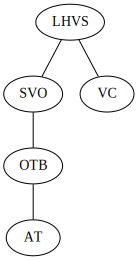

In [38]:
#draw the graph

jointree=elimination_to_jointree(('C', 'B', 'A', 'T', 'O', 'L', 'V', 'S', 'H'),icu_factors,outcomeSpace)
drawgraph(jointree)

By the way, we can use the following function to build a seperator for a jointree. Seperator will be used in the later query function when doing message propagation.This function receive two arguments which are the two key property for building a join tree in our method: 
```   
1. A list which the expected input are all clusters in a jointree called "order_list"
2. A list which the expected input are the add_edge index called "edge_lidex"
```

In [39]:
def build_seperator(li1,li2):
    """
    argument
    `li1`, a list which indicates all the maximum clusters
    `li2`, a list which indicates the egde which should be added 
    

    Returns a dict seperetors in one edge between two clusters
    """
    l1=li1.copy()
    l2=li2.copy()
    new_d=dict()
    for j in range(len(l2)):
        s="".join(set(l1[l2[j][0]])&set(l1[l2[j][1]]))
        if s!='':
            #use sorted in order to make the sequence of the key always equal to the key in push function
            skey=sorted([l1[l2[j][0]],l1[l2[j][1]]]) 
            new_d[skey[0]+skey[1]]=s

    return new_d


S=build_seperator(order_list,edge_index)
print(S)

# The output is a dict. Key is the union of two clusters and the value is the seperator in the edge which between these two clusters.

{'LHVSSVO': 'VS', 'OTBSVO': 'O', 'ATOTB': 'T', 'LHVSVC': 'V'}


## 3.3 A function to set evidence

The inclusion of evidence allows us to answer queries of the form $P(X, e)$ and, after normalization, $P(X|e)$. There are two main ways to include evidence:

1. Eliminate the rows of the factors that do not match the evidence.
2. Create a new factor, known as evidence indicator, that associates a value 1 to the evidence and 0 otherwise.

In [40]:
# We make some modification of the evidence functino in the tutorial. We compute the new outcomeSpcae by evidence variable and its value,
# then we return it.

def set_evidence(outcomeSpace, **q_evi):
    """
    argument 
    `outcomeSpace`, dictionary with the domain of each variable
    `q_evi`, dictionary of evidence in the form of variables names and values
    
    Returns dictionary with evidence factors 
    """     
    # Create an empty dictionary
    lambdas = dict()
    newOutcomeSpace = outcomeSpace.copy()
    for var, evi in q_evi.items():
        # Create an empty dictionary insde lambdas
        lambdas[var] = dict()
        # Domain of the evidence indicator (single variable)
        lambdas[var]['dom'] = tuple(var)
        # Probability table for the evidence indicator 
        lambdas[var]['table'] = odict(((v,),int(v==evi)) for v in outcomeSpace[var])
        newOutcomeSpace[var] = (evi,)
    
    return lambdas,newOutcomeSpace

l,outspace = set_evidence(outcomeSpace, V=1)
print("l=",l)
print("new outcomeSpace=",outspace)

# The output indicates the evidence variable dict and the new outcomeSpace dict

l= {'V': {'dom': ('V',), 'table': OrderedDict([((0,), 0), ((1,), 1)])}}
new outcomeSpace= {'H': (0, 1), 'L': (0, 1), 'A': (0, 1), 'V': (1,), 'S': (0, 1), 'T': (0, 1), 'C': (0, 1, 2), 'O': (0, 1, 2), 'B': (0, 1, 2)}


## 3.4  A function to answer a query based on the jointree clusters

We can compute the marginals for one or more variables inside the same cluster. 

`queryCluster` takes as input a node and a query, among other arguments. The query is a list of variable names. All variables must be in the node cluster. The function returns the marginal distribution for those variables. We can also include an evidence in our query. 

Following are some helper functions which modified from the tutorial, we add normalize step in the message probagation part. Because we notice that
if we do not do normalization, the result for query is a numerical value instead of a probability.

In [41]:
def normalize(f):
    """
    argument 
    `f`, factor to be normalized.
    
    Returns a new factor f' as a copy of f with entries that sum up to 1
    """ 
    table = list()
    sum = 0
    for k, p in f['table'].items():
        sum = sum + p
    for k, p in f['table'].items():
        table.append((k, p/sum))
    return {'dom': f['dom'], 'table': odict(table)}


def getMessages_e(factors, root, eTree, S, lambdas, outcomeSpace):
    """
    argument 
    `factors`, dictionary with all factors.
    `root`, root node.
    `eTree`, elimination tree.
    `S`, separators dictionary.
    'lambdas', evidence factors
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns dictionary with all messages
    """     
    messages = dict()   
    for v in eTree[root]:
        messages[v+root] = pull_e(v, root, factors, eTree, S, messages, lambdas, outcomeSpace)

    for v in eTree[root]:
        messages[root+v] = factors[root]
        if (root in lambdas.keys()):
            messages[root+v] = join(messages[root+v], lambdas[root], outcomeSpace)        
        for w in eTree[root]:
            if not v == w:
                messages[root+v] = join(messages[root+v], messages[w+root], outcomeSpace)
        for w in messages[root+v]['dom']:
            if not w in S[''.join(sorted([v,root]))]:               
                messages[root+v] = marginalize(messages[root+v], w, outcomeSpace)        
        push_e(v, root, factors, eTree, S, messages, lambdas, outcomeSpace)
    return messages

def pull_e(root, previous, factors, eTree, S, messages, lambdas, outcomeSpace):
    """
    argument 
    `root`, current node.
    `previous`, node we came from in the search.
    `factors`, dictionary with all factors.
    `eTree`, elimination tree.
    `S`, separators dictionary.
    'lambdas', evidence factors
    `messages`, dictionary with messages.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a factor fx with a message from node previous to root
    """
    fx = factors[root]
    if (root in lambdas.keys()):
        fx = join(fx, lambdas[root], outcomeSpace)
    for v in eTree[root]:
        if not v == previous:
            messages[v+root] = pull_e(v, root, factors, eTree, S, messages, lambdas, outcomeSpace)
            fx = join(fx, messages[v+root], outcomeSpace)
    for v in fx['dom']:
        if not v in S[''.join(sorted([previous,root]))]:
            fx = marginalize(fx, v, outcomeSpace)
    return fx

def push_e(root, previous, factors, eTree, S, messages, lambdas, outcomeSpace):
    """
    argument 
    `root`, factor to be marginalized.
    `previous`, variable to be summed out.
    `factors`, dictionary with all factors.
    `eTree`, elimination tree.
    `S`, separators dictionary.
    'lambdas', evidence factors
    `messages`, dictionary with messages.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a factor fx with a message from node previous to root
    """    
    for v in eTree[root]:
        if not v == previous:
            messages[root+v] = factors[root]
            if (root in lambdas.keys()):
                messages[root+v] = join(messages[root+v], lambdas[root], outcomeSpace)
            for w in eTree[root]:
                if not v == w:
                    messages[root+v] = join(messages[root+v], messages[w+root], outcomeSpace)

            for w in messages[root+v]['dom']:
                if not w in S[''.join(sorted([v,root]))]:                   
                    messages[root+v] = marginalize(messages[root+v], w, outcomeSpace)
            push_e(v, root, factors, eTree, S, messages, lambdas, outcomeSpace)
            

            

def join2(factors, order, outcomeSpace, li):
    """
    argument 
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable
    'li', a list which indicates all the clusters in a jointree
    
    Returns a new factor which equals to the clusters in a jointree
    """
    # Let's make a copy of factors, so we can freely modify it without distroying the original dictionary
    f = factors.copy()
    l = li.copy()
    nf={}
    # We process the factor in elimination order
    for i, var in enumerate(order):
        # This is the domain of the new factor. We use sets as it is handy to eliminate duplicate variables
        newFactorDom = set()
        # This is a list of factors that will be removed from f because they were joined with other factors
        listFactorsRemove = list()
        # This is a flag to indicate if we are processing the first factor
        first = True
        # Lets iterate over all factors
        for f_id in f.keys():
            # and select the ones that have the variable to be eliminated
            if var in f[f_id]['dom']:
                if first:
                    # We need this code since join requires two factors, so we save the first one in fx and wait for the next
                    fx = f[f_id]
                    first = False
                else:
                    # Join fx and f[f_id] and save the result in fx
                    fx = join(fx, f[f_id], outcomeSpace)
                # f_id was joined, so we will need to eliminate it from f later. Let's save that factor id for future removal
                listFactorsRemove.append(f_id)
                # print(listFactorsRemove)
        # Now, we need to remove var from the domain of the new factor doing a marginalization
        if "".join(fx['dom']) in l:
            nf["".join(fx['dom'])] = fx
        #node.append(fx['dom'])
        fx = marginalize(fx, var, outcomeSpace)
        #edge.append(fx['dom'])
        # Now, we remove all factors that we joined in the simulation. We do it outside the for loop since it modifies the data structure
        for f_id in listFactorsRemove:
            del f[f_id]
        # We will create a new factor with id equal a sequential number and insert it into f, so it can be used in future joins
        f[i] = fx
    
    return nf

The following function is used to answer a query based on jointree clusters. In order to answer a such query, we need to probagate messages in 
the jointree.

In [42]:
def queryCluster(factors, eTree, messages, node, query,outcomeSpace):
    """
    argument 
    `factors`, dictionary with all factors.
    `eTree`, elimination tree.
    `messages`, dictionary with messages between neighbouring nodes
    `node`, a node in the elimination tree whose cluster contain the query variables.
    `query`, a list with query variables
    'outcomeSpace', an outcomeSpace which consistent with the evidence
    
    Returns factor with the marginal for the query variables
    """ 
    # fx is an auxiliary factor. Initialize fx with the factor associated with the root node    
    fx = factors[node]    
    for v in eTree[node]:
        # Call join to multiply the incomming messages from all nodes but v        
        fx = join(fx, messages[v+node], outcomeSpace)
    for v in fx['dom']:
        if not v in query:
            # Call marginalize to remove variable v from fx domain            
            fx = marginalize(fx, v, outcomeSpace)
    return normalize(fx)

Following is a helper functino which converts a factor dict to a DAG

In [43]:
def factor_to_graph(f):
    """
    argument 
    `factor`, factor dictionary.
    
    Return the directed grpah of f
    """
    g = defaultdict(list)
    for k in f.keys():
        for n in f[k]['dom']:
            if n == k:
                continue
            g[n].append(k)
    return g

The following function  query_t3 is used for answering query for task 3.4.

In [44]:
def query_t3(factors,outcomeSpace,q_var,**e_var):
    """
    argument 
    `factor`, factor dictionary.
    `outcomeSpace`, factor dictionary.
    `q_var`, factor dictionary.
    `**e_var`, factor dictionary.
    
    Return the directed grpah of f
    """
    # build a DAG from factors
    graph=factor_to_graph(factors)
    # generate the elimination order
    order=stochastic_minDegree_and_minFill(graph)
    # set evidence and compute new outcomeSpace
    l,new_outSpace=set_evidence(outcomeSpace,**e_var)
    #build jointree
    jointree=elimination_to_jointree(order,factors,new_outSpace)
    #select root and node
    for k,v in jointree.items():
        if set(''.join(q_var)).issubset(k):
            node=k
            root=k
            break
    # build seperator
    S=build_seperator(order_list,edge_index)
    # compute new_factor
    new_fac=join2(factors, order, new_outSpace, order_list)
    # message propagate
    m = getMessages_e(new_fac, root, jointree, S,l, new_outSpace)
    # answer query
    answer=queryCluster(new_fac, jointree, m, node, q_var,new_outSpace)
    return answer

printFactor(query_t3(icu_factors,outcomeSpace,['B'],O=1,T=1))

|   B |   Pr |
|-----+------|
|   0 | 0.02 |
|   1 | 0.49 |
|   2 | 0.49 |


## 3.5 Four functions that provide the following jointree transformations:    add a variable,      merge clusters, add a cluster and remove a cluster.

The following four transformations preserve all three properties of a jointree

### 3.5.1 Add a variable

First, let's draw the graph of the oringinal jointree, in order to make comparison with the four different action 

Original jointree is: {'LHVS': ['SVO', 'VC'], 'SVO': ['OTB', 'LHVS'], 'OTB': ['AT', 'SVO'], 'VC': ['LHVS'], 'AT': ['OTB']}


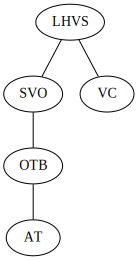

In [45]:
jointree=elimination_to_jointree(('C', 'B', 'A', 'T', 'O', 'L', 'V', 'S', 'H'),icu_factors,outcomeSpace)
print('Original jointree is:',jointree)
drawgraph(jointree)

The following function is used to add a variable to a cluster in a jointree. 
Add variable: We can add a variable X to a cluster Ci as long as Ci has a neighbour Cj that contains X

In [46]:
def add_variable(dic,cluster,var):
    """
    argument 
    'dic', a dict which refer to a jointree
    'cluster', a str which refer to a cluster in the jointree
    'var', a str refer to a variable which you want to add
    
    Returns a new dict which refer to a jointree
    """ 
    l1=order_list.copy()
    l2=edge_index.copy()
    d=copy.deepcopy(dic)
    # if the input cluster is invaild, return False
    if not cluster in l1:
        return False
    for j in range(len(l2)):
        if l1[l2[j][0]]==cluster:
            if set(var).issubset(set(l1[l2[j][1]])):
                # update the jointree dict, using dict[key+var] to replace dict[key] and then delete dict[key], this is one way for update dict
                d[cluster+var]=d[cluster]
                del d[cluster] 
                # update the jointree dict, find all the value which is equal to the old cluster, replace it with cluster+var
                for k,v in d.items():  
                    for i in range(len(v)):
                        if v[i]==cluster:
                            v[i]=cluster+var
                # add var only once, otherwise the var will add (how much neighbors contains var) times
                break
    return d

New jointree is: {'LHVS': ['SVOB', 'VC'], 'OTB': ['AT', 'SVOB'], 'VC': ['LHVS'], 'AT': ['OTB'], 'SVOB': ['OTB', 'LHVS']}


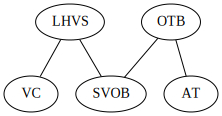

In [47]:
# Test 1

addv_jt=add_variable(jointree,"SVO","B")
print('New jointree is:',addv_jt)
drawgraph(addv_jt)

New jointree is: {'SVO': ['OTB', 'LHVSC'], 'OTB': ['AT', 'SVO'], 'VC': ['LHVSC'], 'AT': ['OTB'], 'LHVSC': ['SVO', 'VC']}


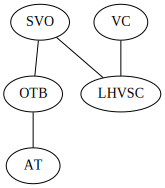

In [48]:
# Test 2

addv_jt2=add_variable(jointree,"LHVS","C")
print('New jointree is:',addv_jt2)
drawgraph(addv_jt2)

### 3.5.2 Merge culsters

Following function is used merge two clusters in a jointree
We can merge two neighbouring clusters Ci and Cj into a single cluster Ck = Ci ∪ Cj, where Ck inherits the neighbours of Ci and Cj

In [49]:
def merge_cluster(dic,c1,c2):
    """
    argument 
    `dic`, a dict which refer to a jointree
    'c1', a str refer to a cluster in a dict
    'c2', a str refer to a cluster in a dict
    
     Returns a new dict which refer to a jointree
    """ 
    d=copy.deepcopy(dic)
    l1=order_list.copy()
    l2=edge_index.copy()
    newc=[]
    c1neighbor=[]
    c2neighbor=[]
    # if cluster1 or cluster2 is not a cluster in jointree, return False
    if not c1 in l1 or not c2 in l1:
        return False
    for k in d.keys():
        if k==c1 or k==c2:
            newc.append(k)
    # add cluster to the jointree dict
    for key,value in d.items():
        if key==c1:
            for i in range(len(value)):
                if value[i]!=c2:
                    c1neighbor.append(value[i])
        if key==c2:
            for i in range(len(value)):
                if value[i]!=c1:
                    c2neighbor.append(value[i])
    # if cluster1 and cluster2 are not leaf node of a tree
    if len(c1neighbor)>0 and len(c2neighbor)>0:
        d["".join(sorted(newc))]=[''.join(c1neighbor),''.join(c2neighbor)]
    # if cluster1 is a leaf node of a tree
    elif len(c1neighbor)==0 and len(c2neighbor)>0:
        d["".join(sorted(newc))]=[''.join(c2neighbor)]
    # if cluster2 is a leaf node of a tree
    else:
        d["".join(sorted(newc))]=[''.join(c1neighbor)]
    del d[c1]
    del d[c2]
    #update the jointree dict, revome node which previous neighbor is c1 or c2, and insert the merged cluster to its neighbor
    for k,v in d.items():
        for j in range(len(v)):
            if v[j]==c1 or v[j]==c2:
                del v[j]
                if len(v)==0:
                    v.append("".join(sorted(newc)))
                break

    return d

{'LHVS': ['VC'], 'VC': ['LHVS'], 'AT': ['OTBSVO'], 'OTBSVO': ['LHVS', 'AT']}


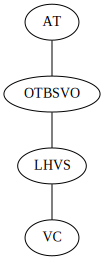

In [50]:
# Test1

merge_jt=merge_cluster(jointree,"SVO","OTB")
print(merge_jt)
drawgraph(merge_jt)

{'LHVS': ['SVO', 'VC'], 'SVO': ['LHVS'], 'VC': ['LHVS'], 'ATOTB': ['SVO']}


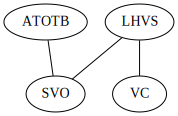

In [51]:
# Test2

merge_jt2=merge_cluster(jointree,"AT","OTB")
print(merge_jt2)
drawgraph(merge_jt2)

### 3.5.3 Add a cluster

Following function is used to add a cluster to a cluster existed in a jointree
We can add a new cluster Cj and make it a neighbour of an existing cluster Ci as long as Cj ⊆ Ci

In [52]:
def add_cluster(dic,cluster,addCluster):
    """
    argument 
    `dic`, a dict which refer to a jointree
    'cluster', a str refer to a cluster in a dict
    'addCluster', a str refer to a cluster which you want to add it into your jointree
    
    Returns a new dict which refer to a jointree
    """ 
    d=copy.deepcopy(dic)
    l1=order_list.copy()
    l2=edge_index.copy()
    # if the cluster which you want to add is not a subset of the target cluster, return False
    if not set(addCluster).issubset(set(cluster)):
        return False
    # add the input cluster to target cluster and update the jointree dict
    for k,v in d.items():
        if k==cluster:
            v.append(addCluster)
            d[addCluster]=[cluster]
            break # add just perform once, break for reducing the running time
    return d
            

{'LHVS': ['SVO', 'VC'], 'SVO': ['OTB', 'LHVS'], 'OTB': ['AT', 'SVO'], 'VC': ['LHVS', 'C'], 'AT': ['OTB'], 'C': ['VC']}


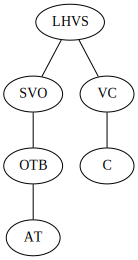

In [53]:
# Test1

addc_jt=add_cluster(jointree,"VC","C")
print(addc_jt)
drawgraph(addc_jt)

{'LHVS': ['SVO', 'VC'], 'SVO': ['OTB', 'LHVS', 'S'], 'OTB': ['AT', 'SVO'], 'VC': ['LHVS'], 'AT': ['OTB'], 'S': ['SVO']}


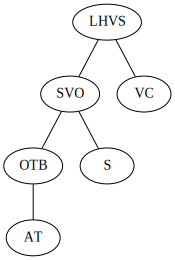

In [54]:
# Test2

addc_jt2=add_cluster(jointree,"SVO","S")
print(addc_jt2)
drawgraph(addc_jt2)

### 3.5.4 Delete a cluster

This function is used to delete a cluster in a jointree.
We can add a new cluster Cj and make it a neighbour of an existing cluster Cj as long as Cj ⊆ Ci

In [55]:
# This function is used to delete a cluster in a jointree
# We can add a new cluster Cj and make it a neighbour of an existing cluster Cj as long as Cj ⊆ Ci

def del_cluster(dic,cluster):
    """
    argument 
    `dic`, a dict which refer to a jointree
    'cluster', a str refer to a cluster in a dict that you want to delete
    
    
    Returns a new dict which refer to a jointree
    """ 
    d=copy.deepcopy(dic)
    l1=order_list.copy()
    l2=edge_index.copy()
    
    # if the cluster you want to delete has more than one neighbor, return False
    for k,v in d.items():
        if k==cluster:
            if len(v)>1:
                return False                      
            else: # first, delete the cluster key in the jointree dict
                del d[cluster]
                break #delete just perfrom once,break for reducing the running time
    # then delete the cluster which appears in other key's value
    for k2,v2 in d.items():
        for i in range(len(v2)):
            if v2[i]==cluster:
                del v2[i]
                break  # one value list only contains one delete cluster, so break to reduce running time
    return d

{'LHVS': ['SVO', 'VC'], 'SVO': ['OTB', 'LHVS'], 'OTB': ['SVO'], 'VC': ['LHVS']}


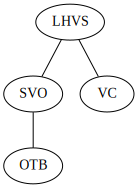

In [56]:
# Test1

del_jt=del_cluster(jointree,"AT")
print(del_jt)
drawgraph(del_jt)

{'LHVS': ['SVO'], 'SVO': ['OTB', 'LHVS'], 'OTB': ['AT', 'SVO'], 'AT': ['OTB']}


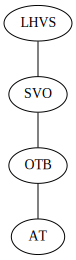

In [57]:
# Test2

del_jt2=del_cluster(jointree,"VC")
print(del_jt2)
drawgraph(del_jt2)

# Benchmark

Here is some benchmark for task3, we will analyse them in the report.

In [58]:
# This function is used to transform the str outcomeSpace to a integer outcomeSpace

def ttransform(f, os):
    ff = deepcopy(f)
    o = deepcopy(os)
    d = dict()
    for k, v in os.items():
        #v
        d[k] = dict(zip(v, range(len(v))))
        o[k] = tuple(list(range(len(v))))
    
    for k, v in f.items():
        ff[k] = dict()
        ff[k]['dom'] = f[k]['dom']
        ff[k]['table'] = odict()
        
        for kk, vv in f[k]['table'].items():
            it = iter(list(f[k]['dom']))
            l = []
            for i in kk:
                node = next(it)
                l.append(d[node][i])
            l = tuple(l)
            ff[k]['table'][l] = vv

    return ff, o

# This function is used to transform a factor to a directed graph

def factor_to_graph(f):
    """
    argument 
    `factor`, factor dictionary.
    
    Return the directed grpah of f
    """
    g = defaultdict(list)
    for k in f.keys():
        for n in f[k]['dom']:
            if n == k:
                continue
            g[n].append(k)
    return g


def width(factors, order):
    """
    argument 
    `factors`, a dictionary of factors, each factor is a dictionary of domain and probability values,
    `order`, a list of variable names specifying an elimination order.
    
    Returns the width of the elimination order, i.e., the number of variables of the largest factor
    """    
    
    # Initialize w, a variable that has a width of the elimination order
    w = 0
    # Let's make a copy of factors, so we can freely modify it without distroying the original dictionary
    f = factors.copy()
    # We process the factor in elimination order
    for i, var in enumerate(order):
        # This is the domain of the new factor. We use sets as it is handy to eliminate duplicate variables
        newFactorDom = set()
        # This is a list of factors that will be removed from f because they were joined with other factors
        listFactorsRemove = list()
        # Lets iterate over all factors
        for f_id in f.keys():
            # and select the ones that have the variable to be eliminated
            if var in f[f_id]['dom']:
                # Merge the newFactorDomain list with the domain of f_id
                newFactorDom.update(f[f_id]['dom'])
                # Update the list of factors to remove by appending f_id
                listFactorsRemove.append(f_id)
        # Now, we need to remove var from the domain of the new factor. We are simulating a summation
        newFactorDom.remove(var)            # Remove var from the list new_dom by calling the method remove(). 1 line
        # Let's check if we have found a new largest factor
        if len(newFactorDom) > w:
            w = len(newFactorDom)
        # Now, we remove all factors that we joined in the simulation. We do it outside the for loop since it modifies the data structure
        for f_id in listFactorsRemove:
            del f[f_id]
        # We will create a new factor with id equal a sequential number and insert it into f, so it can be used in future joins
        f[i] = dict()
        # We only insert the factor domain, since it is all that we need to simulate the elimination and measure width
        f[i]['dom'] = tuple(newFactorDom)
    return w



f,o=load_from_file('child.net')
factors,outcomeSpace=ttransform(f,o)

In [59]:
order = stochastic_minDegree_and_minFill(factor_to_graph(factors))

In [60]:
order

['BirthAsphyxia',
 'CO2Report',
 'CO2',
 'GruntingReport',
 'LVHreport',
 'LVH',
 'RUQO2',
 'XrayReport',
 'Age',
 'ChestXray',
 'Grunting',
 'LowerBodyO2',
 'LungFlow',
 'Sick',
 'Disease',
 'DuctFlow',
 'CardiacMixing',
 'HypDistrib',
 'HypoxiaInO2',
 'LungParench']

In [61]:
# The first test, has 20 nodes and 230 parameters


######################
# Test code
print("Elimination order width: %d" % width(factors, order))

%time jt=elimination_to_jointree(order,factors,outcomeSpace)


Elimination order width: 3
Wall time: 5.03 ms


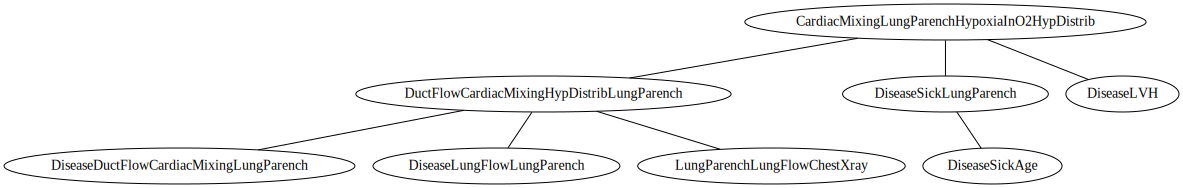

In [62]:
drawgraph(jt)

In [63]:
f,o=load_from_file('andes.net')
factors,outcomeSpace=ttransform(f,o)

In [64]:
order = stochastic_minDegree_and_minFill(factor_to_graph(factors))
order

['GIVEN_1',
 'HORIZ53',
 'TRY13',
 'TRY14',
 'TRY15',
 'TRY12',
 'TRY26',
 'TRY25',
 'CHOOSE19',
 'CHOOSE35',
 'CHOOSE47',
 'CHOOSE62',
 'DISPLACEM0',
 'FIND58',
 'GOAL_99',
 'GIVEN21',
 'GOAL_2',
 'GRAV2',
 'GRAV78',
 'SNode_151',
 'IDENTIFY22',
 'IDENTIFY41',
 'IDENTIFY59',
 'KINEMATI17',
 'KNOWN8',
 'NEED1',
 'NEWTONS45',
 'RApp2',
 'SLIDING4',
 'SNode_15',
 'SNode_24',
 'SNode_31',
 'SNode_40',
 'SNode_46',
 'SNode_9',
 'SYSTEM46',
 'TRY24',
 'TRY76',
 'VELOCITY7',
 'WEIGHT57',
 'WRITE30',
 'APPLY32',
 'GOAL_84',
 'SNode_86',
 'NORMAL52',
 'RApp1',
 'SNode_21',
 'SNode_3',
 'APPLY61',
 'DEFINE23',
 'FIND49',
 'IDENTIFY10',
 'IDENTIFY39',
 'IDENTIFY43',
 'IDENTIFY9',
 'NORMAL50',
 'SNode_25',
 'RESOLVE37',
 'RESOLVE38',
 'RESOLVE40',
 'RESOLVE42',
 'SNode_17',
 'SYSTEM18',
 'SNode_68',
 'GOAL_50',
 'SNode_51',
 'SNode_7',
 'SNode_71',
 'VECTOR70',
 'WRITE31',
 'WRITE63',
 'SNode_156',
 'APPLY77',
 'GOAL_150',
 'EQUAL71',
 'SNode_119',
 'SNode_52',
 'FORCE60',
 'NULL48',
 'SNode_65',

In [65]:
# The second test, has 223 nodes and 1157 parameters

print("Elimination order width: %d" % width(factors, order))
%time jt=elimination_to_jointree(order,factors,outcomeSpace)

# The jointree is massive, so we dont plot it

Elimination order width: 16
Wall time: 2.79 s


In [66]:
f,o=load_from_file('pathfinder.net')
factors,outcomeSpace=ttransform(f,o)

In [67]:
order = stochastic_minDegree_and_minFill(factor_to_graph(factors))
order

['F1',
 'F10',
 'F108',
 'F12',
 'F14',
 'F19',
 'F23',
 'F24',
 'F25',
 'F26',
 'F27',
 'F28',
 'F29',
 'F33',
 'F34',
 'F35',
 'F36',
 'F37',
 'F43',
 'F45',
 'F46',
 'F51',
 'F57',
 'F58',
 'F59',
 'F60',
 'F63',
 'F64',
 'F65',
 'F67',
 'F68',
 'F69',
 'F7',
 'F73',
 'F75',
 'F76',
 'F77',
 'F79',
 'F80',
 'F9',
 'F91',
 'F92',
 'F101',
 'F102',
 'F103',
 'F104',
 'F105',
 'F106',
 'F11',
 'F13',
 'F15',
 'F16',
 'F22',
 'F21',
 'F90',
 'F32',
 'F42',
 'F47',
 'F49',
 'F50',
 'F52',
 'F55',
 'F54',
 'F6',
 'F62',
 'F66',
 'F61',
 'F71',
 'F95',
 'F99',
 'F100',
 'F4',
 'F107',
 'F17',
 'F18',
 'F2',
 'F5',
 'F3',
 'F78',
 'F97',
 'F30',
 'F74',
 'F98',
 'F38',
 'F40',
 'F48',
 'F53',
 'F56',
 'F8',
 'F70',
 'F81',
 'F93',
 'F94',
 'F39',
 'F96',
 'F82',
 'F86',
 'F89',
 'F83',
 'F87',
 'F88',
 'F31',
 'F20',
 'F41',
 'F44',
 'F72',
 'F84',
 'F85',
 'Fault']

In [68]:
# The third test, has 109 nodes and 77155 parameters

print("Elimination order width: %d" % width(factors, order))
%time jt=elimination_to_jointree(order,factors,outcomeSpace)

# The jointree is massive, so we dont plot it

Elimination order width: 6
Wall time: 907 ms


In [69]:
f,o=load_from_file('pigs.net')
factors,outcomeSpace=ttransform(f,o)

In [70]:
order = stochastic_minDegree_and_minFill(factor_to_graph(factors))
order

['p197075886',
 'p751230786',
 'p197119188',
 'p197125588',
 'p543378087',
 'p197130288',
 'p197130888',
 'p82141488',
 'p197132888',
 'p277114088',
 'p197143789',
 'p197149689',
 'p197162589',
 'p82191389',
 'p197168789',
 'p197206590',
 'p197240391',
 'p197240491',
 'p197252391',
 'p197252591',
 'p197258291',
 'p197258391',
 'p197258591',
 'p197276591',
 'p197288691',
 'p197288791',
 'p197303091',
 'p197303191',
 'p197201290',
 'p197303291',
 'p197314191',
 'p197318792',
 'p197343392',
 'p197353592',
 'p216124491',
 'p216124591',
 'p230057992',
 'p230416387',
 'p230433487',
 'p603176686',
 'p230474587',
 'p230537588',
 'p251336689',
 'p230565789',
 'p237016791',
 'p237017391',
 'p251428590',
 'p237082692',
 'p237082792',
 'p251226287',
 'p251337389',
 'p251388889',
 'p251463690',
 'p251506491',
 'p251564791',
 'p277111088',
 'p277195691',
 'p277155690',
 'p277195791',
 'p277162190',
 'p392087690',
 'p82065086',
 'p392115290',
 'p627270088',
 'p392115490',
 'p392115590',
 'p392120790'

In [71]:
# The forth test, has 441 nodes and 5618 parameters

print("Elimination order width: %d" % width(factors, order))
%time jt=elimination_to_jointree(order,factors,outcomeSpace)

# The jointree is massive, so we dont plot it

Elimination order width: 11
Wall time: 9.03 s


In [72]:
f,o=load_from_file('link.net')
factors,outcomeSpace=ttransform(f,o)

In [73]:
order = stochastic_minDegree_and_minFill(factor_to_graph(factors))
order

['D0_10_d_p',
 'D0_11_d_p',
 'D0_12_d_p',
 'D0_13_d_p',
 'D0_14_d_p',
 'D0_15_d_p',
 'D0_16_d_p',
 'D0_17_d_p',
 'D0_18_d_p',
 'D0_19_d_p',
 'D0_1_d_p',
 'D0_20_d_p',
 'D0_21_d_p',
 'D0_22_d_p',
 'D0_23_d_p',
 'D0_24_d_p',
 'D0_25_d_p',
 'D0_26_d_p',
 'D0_27_d_p',
 'D0_28_d_p',
 'D0_29_d_p',
 'D0_2_d_p',
 'D0_30_d_p',
 'D0_31_d_p',
 'D0_32_d_p',
 'D0_33_d_p',
 'D0_34_d_p',
 'D0_35_d_p',
 'D0_36_d_p',
 'D0_37_d_p',
 'D0_38_d_p',
 'D0_39_d_p',
 'D0_3_d_p',
 'D0_40_d_p',
 'D0_41_d_p',
 'D0_42_d_p',
 'D0_43_d_p',
 'D0_44_d_p',
 'D0_45_d_p',
 'D0_46_d_p',
 'D0_47_d_p',
 'D0_48_d_p',
 'D0_49_d_p',
 'D0_4_d_p',
 'D0_50_d_p',
 'D0_51_d_p',
 'D0_52_d_p',
 'D0_53_d_p',
 'D0_54_d_p',
 'D0_55_d_p',
 'D0_56_d_p',
 'D0_57_d_p',
 'D0_58_d_p',
 'D0_59_d_p',
 'D0_5_d_p',
 'D0_60_d_p',
 'D0_61_d_p',
 'D0_62_d_p',
 'D0_63_d_p',
 'D0_64_d_p',
 'D0_65_d_p',
 'D0_66_d_p',
 'D0_67_d_p',
 'D0_68_d_p',
 'D0_69_d_p',
 'D0_6_d_p',
 'D0_70_d_p',
 'D0_71_d_p',
 'D0_72_d_p',
 'D0_73_d_p',
 'D0_7_d_p',
 'D0_8_d_p',


In [74]:
# The fifth test, has 724 nodes and 14211 parameters

print("Elimination order width: %d" % width(factors, order))
%time jt=elimination_to_jointree(order,factors,outcomeSpace)

# The jointree is massive, so we dont plot it

Elimination order width: 15
Wall time: 4min 45s


In [75]:
f,o=load_from_file('munin.net')
factors,outcomeSpace=ttransform(f,o)

In [76]:
order = stochastic_minDegree_and_minFill(factor_to_graph(factors))
order

['L_ADM_MUPINSTAB',
 'L_ADM_MUPSATEL',
 'L_ADM_MVA_AMP',
 'L_ADM_QUAL_MUPAMP',
 'L_ADM_QUAL_MUPDUR',
 'L_ADM_QUAL_MUPPOLY',
 'L_ADM_QUAN_MUPAMP',
 'L_ADM_MUPAMP',
 'L_ADM_QUAN_MUPDUR',
 'L_ADM_MUPDUR',
 'L_ADM_REPSTIM_CMAPAMP',
 'L_ADM_REPSTIM_DECR',
 'L_ADM_REPSTIM_FACILI',
 'L_ADM_REPSTIM_POST_DECR',
 'L_ADM_SF_DENSITY',
 'L_ADM_SF_JITTER',
 'L_ADM_SPONT_DENERV_ACT',
 'L_ADM_SPONT_HF_DISCH',
 'L_ADM_SPONT_INS_ACT',
 'L_ADM_SPONT_NEUR_DISCH',
 'L_ADM_TA_CONCL',
 'L_APB_MUPINSTAB',
 'L_APB_MUPSATEL',
 'L_APB_MVA_AMP',
 'L_APB_QUAL_MUPAMP',
 'L_APB_QUAL_MUPDUR',
 'L_APB_QUAL_MUPPOLY',
 'L_APB_QUAN_MUPAMP',
 'L_APB_MUPAMP',
 'L_APB_QUAN_MUPDUR',
 'L_APB_MUPDUR',
 'L_APB_REPSTIM_CMAPAMP',
 'L_APB_REPSTIM_DECR',
 'L_APB_REPSTIM_FACILI',
 'L_APB_REPSTIM_POST_DECR',
 'L_APB_SF_DENSITY',
 'L_APB_SF_JITTER',
 'L_APB_SPONT_DENERV_ACT',
 'L_APB_SPONT_HF_DISCH',
 'L_APB_SPONT_INS_ACT',
 'L_APB_SPONT_NEUR_DISCH',
 'L_APB_TA_CONCL',
 'L_AXIL_AMP_E',
 'L_AXIL_LAT_ED',
 'L_DELT_MUPINSTAB',
 'L_DELT_M

In [77]:
# The last test, has 1041 nodes and 80592 parameters

print("Elimination order width: %d" % width(factors, order))
%time jt=elimination_to_jointree(order,factors,outcomeSpace)

# The jointree is massive, so we dont plot it

Elimination order width: 8
Wall time: 1min 53s


# Task4    Approximate inference

## 4.1 A function that let the user specify the number of chains.<br> 

### In this function, we ask user to specify the number of chains and randomly init all chains for the next step

In [78]:
def set_chain_nb(factor, os, nb, e):
    """
    argument 
    `factor`, a factor dict
    `os`, outcomespace dict
    `nb`, number of chains
    `e`, evidence dict
    
    
    Returns a new dict which stores information needed for the next step
    """ 
    f = deepcopy(factor)
    os = deepcopy(os)
    for ee in e:
        os = evidence(ee, e[ee], os)
    # all need to be given    
    variable_list = list(os.keys() - e.keys())
    ll = list(sorted(os.keys()))
    # dict sotring mapping info. like node A : index 0
    variable_mapping = dict(zip(ll, range(len(os.keys()))))
    # reverse dict of variable_mapping
    index_mapping = dict(zip(range(len(os.keys())), ll))
    # init chains
    chains = [deque() for i in range(nb)]
    for i in range(len(chains)):
        l = []
        for v in sorted(os.keys()):
            if v in e.keys():
                l.append(e[v])
            else:
                l.append(random.choice(os[v]))
        chains[i].append(tuple(l))
    return {'factor':f, 'os':os, 'chains':chains, 'vm':variable_mapping, 'im':index_mapping, 'vl':variable_list}

            

In [79]:
# usage
d = set_chain_nb(medium_factor, medium_os, 2, {'Disease':'PFC', 'Sick':'yes'})

## 4.2 A function to mix up chains until convergence.<br>

Mixed function check if a window size of samples from several chains are mixed or not. It return R vector as the return value.<br> burn-in fucntion start burn-in period of Gibbs, we check if indicator vector arrays from several chains are mixed or not. If mixed or iterate to the max step, we can start sampling.

In [80]:
def mixed(samples): 
    """
    argument 
    `sample`, samples list

    Returns a vector R
    """
    # convert to numpy
    a = np.array(samples)
    # get sample size
    nn = a.shape[1]
    # get chain size
    cc = a.shape[0]
    # compute theta_j
    thetas = []
    for c in a:
        theta = None
        # samples
        for s in c:
            if theta is None:
                theta = deepcopy(s)
            else:
                theta += s
        theta = theta / nn
        thetas.append(theta)
    # compute theta_mean
    mean_theta = None
    for t in thetas:
        if mean_theta is None:
            mean_theta = deepcopy(t)
        else:
            mean_theta += t
    mean_theta = mean_theta / cc  
    # compute sigma_j
    sigmas = []
    # chain
    it = iter(thetas)
    for c in a:
        theta = next(it)
        sigma = None
        # samples
        for s in c:
            if sigma is None:
                sigma = (s - theta) ** 2
            else:
                sigma += (s - theta) ** 2
        sigma = sigma / (nn - 1)
        sigmas.append(sigma)
    # compute W 
    W = None
    for s in sigmas:
        if W is None:
            W = deepcopy(s)
        else:
            W += s
    W = W / cc
    # compute B
    B = None
    for t in thetas:
        if B is None:
            B = (t - mean_theta) ** 2
        else:
            B += (t - mean_theta) ** 2          
    B = (B * nn) / (cc - 1)
    # remove rows which W is 0
    W = W[np.nonzero(W)]
    B = B[np.nonzero(W)]
    # compute R
    R = np.sqrt((W + ((B - W) / nn)) / W) 
    return R

def s_normalize(f):
    """
    argument 
    `f`, a factor dict
    
    Returns a new factor dict which is the normalised version of f
    """
    table = list()
    sum = 0
    i = 0
    for k, p in f['table'].items():
        sum = sum + p
        i += 1
    if sum == 0:
        for k, p in f['table'].items():
            table.append((k, 1/i))
    else:
        for k, p in f['table'].items():
            table.append((k, p/sum))
    return {'dom': f['dom'], 'table': odict(table)}

def burnin(d, max_step = 1000, window = 20):
    """
    argument 
    `d`, information dict from the previous step
    `max_step`, max iteration step for burin-in period
    `window`, window size for checking mixed
    
    Returns a new dict which stores information needed for the next step
    """
    # get all needed info
    f = d['factor']
    chains = deepcopy(d['chains'])
    samples = [deque() for i in range(len(chains))]
    os = d['os']
    variable_list = d['vl']
    variable_mapping = d['vm']
    im = d['im']
    # init indicator
    indicator = dict()
    ii = 0
    for k, v in os.items():
        for i in v:
            indicator[(k, i)] = ii
            ii += 1
    vvv = deepcopy(variable_list)
        
    # step
    for i in range(max_step):
        # each chain
        for j in range(len(chains)):
            a = chains[j]
            sss = [0] * len(indicator)
            # random shuffle the variable order
            random.shuffle(vvv)
            for v in vvv:      
                # set other variable as fixed value
                temp_os = deepcopy(os)
                temp_list = deepcopy(variable_list)
                temp_list.remove(v)
                for other in temp_list:
                    temp_os = evidence(other, a[-1][variable_mapping[other]], temp_os)
                # to compute P(A|fixed values), we need to join A and its children node CPT
                # get children node
                related_list = set()
                for kk in f:
                    if v in f[kk]['dom']:
                        related_list.add(kk)
                related_list = list(related_list)
                related_list.sort()
                temp_list = related_list.copy()
                temp_list.remove(v)
                # get current sample
                current_sample = tuple([a[-1][variable_mapping[i]] for i in temp_list])
                # compute P(A|other fixed values)
                first = None
                p = None
                for node in related_list:
                    if first is None:
                        first = node
                        p = f[first]
                        for kkk in p['dom']:
                            if kkk != v:
                                p = marginalize(p, kkk, temp_os)
                    else:
                        p = join(p, f[node], temp_os)
                p = s_normalize(p)
                # get probablities
                prob_list = list(p['table'].values())
                # use a random number to generate our choice
                random_number = random.random()
                choice = 0
                for ii in range(1, len(prob_list) + 1):
                    cum_sum_prob = sum(prob_list[: ii])
                    if cum_sum_prob >= random_number:
                        choice = ii - 1
                        break                
                choice = os[v][choice] 
                # set indicator vector
                sss[indicator[(v, choice)]] += 1
                # set new sample
                new_sample = list(a[-1])
                new_sample[variable_mapping[v]] = choice
                new_sample = tuple(new_sample)
                chains[j].append(new_sample)
                chains[j].popleft()
            # add indicator vector as a sample to judge if mixed
            samples[j].append(tuple(sss))
        # when we have enough samples to judge if mixed
        if len(samples[0]) >= window:
            s = None
            # first time we achieve this, we directly check
            if s is None:
                s = 0
                # check R
                r = mixed(samples)    
                if all(r < 1.1):
                    return {'factor':f, 'chains':chains, 'os':os, 'vl':variable_list, 'vm':variable_mapping}
            # the next time we need to resample after window size steps and check
            else:
                s += 1
                if s == window:
                    r = mixed(samples)    
                    if all(r < 1.1):
                        return {'factor':f, 'chains':chains, 'os':os, 'vl':variable_list, 'vm':variable_mapping}
                    s = 0
    return {'factor':f, 'chains':chains, 'os':os, 'vl':variable_list, 'vm':variable_mapping}


In [81]:
# usage, d is the return value of set_chain_nb
s = burnin(d, 10000000, 2000)

## 4.3 A function that samples the chains for a specified number of samples.

<br>Sampling function starts Gibbs sampling and return a pandas datafram which stores samples we generated based on Gibbs sampling

In [82]:
def sampling(d, sample_size):
    """
    argument 
    `d`, information dict from the previous step
    `sample_size`, size of samples need to be generated
    
    Returns a pandas dataframe storing samples we generated
    """
    # get info from dict
    f = d['factor']
    chains = deepcopy(d['chains'][0])
    samples = []
    os = d['os']
    variable_list = d['vl']
    variable_mapping = d['vm']
    position = None
    
    vvv = deepcopy(variable_list)
    # we need to iterator sample_size * len(variable_list) times
    for i in range(sample_size * len(variable_list)):
        # random shuffle the order we resample
        random.shuffle(vvv)
        for v in vvv:
            a = chains
            # set other variable as fixed
            temp_os = deepcopy(os)
            temp_list = deepcopy(variable_list)
            temp_list.remove(v)
            for other in temp_list:
                temp_os = evidence(other, a[-1][variable_mapping[other]], temp_os)
            # get children node
            related_list = set()
            for kk in f:
                if v in f[kk]['dom']:
                    related_list.add(kk)
            related_list = list(related_list)
            related_list.sort()
            temp_list = related_list.copy()
            temp_list.remove(v)
            # get current sample
            current_sample = tuple([a[-1][variable_mapping[i]] for i in temp_list])
            # compute P(A|other fixed values)
            first = None
            p = None
            for node in related_list:
                if first is None:
                    first = node
                    p = f[first]
                    for kkk in p['dom']:
                        if kkk != v:
                            p = marginalize(p, kkk, temp_os)
                else:
                    p = join(p, f[node], temp_os)
            p = s_normalize(p)
            # get probabilities
            prob_list = list(p['table'].values())
            # generate a random number to choose our sample
            random_number = random.random()
            choice = 0
            for ii in range(1, len(prob_list) + 1):
                cum_sum_prob = sum(prob_list[: ii])
                if cum_sum_prob >= random_number:
                    choice = ii - 1
                    break
            choice = os[v][choice]  
            # set new sample value
            new_sample = list(a[-1])
            new_sample[variable_mapping[v]] = choice
            new_sample = tuple(new_sample)
            chains.append(new_sample)
            chains.popleft()
        # add to result list
        samples.append(chains[-1])
        # when we have enough samples return it as dataframe
        if len(samples) == sample_size:
            index = list(sorted(os.keys()))
            df = pd.DataFrame(samples, columns = index)
            return df
    index = list(sorted(os.keys()))
    df = pd.DataFrame(samples, columns = index)
    return df

In [83]:
# usage, s is the return value of burnin
df = sampling(s, 100000)

## 4.4 A function to answer queries based on the samples.


In [84]:
# tutorial code
def estProbTable(data, var_name, parent_names, outcomeSpace):
    """
    Calculate a dictionary probability table by ML given
    `data`, a dictionary or dataframe of observations
    `var_name`, the column of the data to be used for the conditioned variable and
    `var_outcomes`, a tuple of possible outcomes for the conditiona varible and
    `parent_names`, a tuple of columns to be used for the parents and
    `parent_outcomes` a tuple of all possible parent outcomes 
    Return a dictionary containing an estimated conditional probability table.
    """    
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)

    prob_table = odict()
    
    for i, parent_combination in enumerate(all_parent_combinations):
        cond_array = []
        parent_vars = dict(zip(parent_names, parent_combination))
        parent_index = allEqualThisIndex(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            prob_table[tuple(list(parent_combination)+[var_outcome])] = (var_index & parent_index).sum()/parent_index.sum()
            
    return {'dom': tuple(list(parent_names)+[var_name]), 'table': prob_table}



def allEqualThisIndex(dict_of_arrays, **fixed_vars):
    """
    Helper function to create a boolean index vector into a tabular data structure,
    such that we return True only for rows of the table where, e.g.
    column_a=fixed_vars['column_a'] and column_b=fixed_vars['column_b'].
    
    This is a simple task, but it's not *quite* obvious
    for various obscure technical reasons.
    
    It is perhaps best explained by an example.
    
    >>> all_equal_this_index(
    ...    {'X': [1, 1, 0], Y: [1, 0, 1]},
    ...    X=1,
    ...    Y=1
    ... )
    [True, False, False]
    """
    # base index is a boolean vector, everywhere true
    first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
    index = np.ones_like(first_array, dtype=np.bool_)
    for var_name, var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return index

gibbs_query function answer the query Q.

In [85]:
def gibbs_query(Q, data, outcomespace):
    """
    argument 
    `Q`, Query variable list
    `data`, samples dataframe
    `outcomespace`, outcomespace dict
    
    Returns a table of query
    """
    os = deepcopy(outcomespace)
    r = None
    # query all variable and join them together
    for q in Q:
        if r is None:
            r = estProbTable(data, q, [], os)
        else:
            r = join(r, estProbTable(data, q, [], os), os)
    return r



In [86]:
# usage, df is the return value of sampling


# sample test 
# r1 = gibbs_query(['A'], df, s['os'])
# r2 = gibbs_query(['B'], df, s['os'])
# r3 = gibbs_query(['A','B'], df, s['os'])
# printFactor(r1)
# printFactor(r2)
# printFactor(r3)

In [87]:
# r1 = gibbs_query(['Age'], df, s['os'])
# printFactor(r1)

# Benchmark

icu_factor test

In [88]:

icu_factors = {
    'H': {
        'dom': ('H'),
        'table': odict([
            ((0,), 0.80),
            ((1,), 0.20),
        ])
    },

    'V': {
        'dom': ('L', 'H', 'V'),
        'table': odict([
            ((0, 0, 0), 0.05),
            ((0, 0, 1), 0.95),
            ((0, 1, 0), 0.99),
            ((0, 1, 1), 0.01),
            ((1, 0, 0), 0),
            ((1, 0, 1), 1),
            ((1, 1, 0), 1),
            ((1, 1, 1), 0),
        ])
    },

    'C': {
        'dom': ('V', 'C'),
        'table': odict([
            ((0, 0), 0.94),
            ((0, 1), 0.04),
            ((0, 2), 0.02),
            ((1, 0), 0.02),
            ((1, 1), 0.26),
            ((1, 2), 0.72),
        ])
    },

    'L': {
        'dom': ('L'),
        'table': odict([
            ((0,), 0.95),
            ((1,), 0.05),
        ])
    },

    'S': {
        'dom': ('L', 'H', 'S'),
        'table': odict([
            ((0, 0, 0), 0.04),
            ((0, 0, 1), 0.96),
            ((0, 1, 0), 0.48),
            ((0, 1, 1), 0.52),
            ((1, 0, 0), 0.95),
            ((1, 0, 1), 0.05),
            ((1, 1, 0), 0),
            ((1, 1, 1), 1),
        ])
    },

    'O': {
        'dom': ('S', 'V', 'O'),
        'table': odict([
            ((0, 0, 0), 0.97),
            ((0, 0, 1), 0.01),
            ((0, 0, 2), 0.02),
            ((0, 1, 0), 0.78),
            ((0, 1, 1), 0.19),
            ((0, 1, 2), 0.03),
            ((1, 0, 0), 0.22),
            ((1, 0, 1), 0.76),
            ((1, 0, 2), 0.02),
            ((1, 1, 0), 0.01),
            ((1, 1, 1), 0.01),
            ((1, 1, 2), 0.98),
        ])
    },

    'T': {
        'dom': ('A', 'T'),
        'table': odict([
            ((0, 0), 0.30),
            ((0, 1), 0.70),
            ((1, 0), 1),
            ((1, 1), 0),
        ])
    },

    'B': {
        'dom': ('O', 'T', 'B'),
        'table': odict([
            ((0, 0, 0), 1),
            ((0, 0, 1), 0),
            ((0, 0, 2), 0),
            ((0, 1, 0), 0.30),
            ((0, 1, 1), 0.62),
            ((0, 1, 2), 0.08),
            ((1, 0, 0), 0.93),
            ((1, 0, 1), 0.07),
            ((1, 0, 2), 0),
            ((1, 1, 0), 0.02),
            ((1, 1, 1), 0.49),
            ((1, 1, 2), 0.49),
            ((2, 0, 0), 0.90),
            ((2, 0, 1), 0.08),
            ((2, 0, 2), 0.02),
            ((2, 1, 0), 0.01),
            ((2, 1, 1), 0.08),
            ((2, 1, 2), 0.91),
        ])
    },

    'A': {
        'dom': ('A'),
        'table': odict([
            ((0,), 0.99),
            ((1,), 0.01),
        ])
    }
}

outcomeSpace = dict(
    H=(0, 1),
    L=(0, 1),
    A=(0, 1),
    V=(0, 1),
    S=(0, 1),
    T=(0, 1),
    C=(0, 1, 2),
    O=(0, 1, 2),
    B=(0, 1, 2),
)

In [89]:
d = set_chain_nb(icu_factors, outcomeSpace, 2, {'T':1,'O':1})
s = burnin(d, 1000000, 1000)
df = sampling(s, 10000)
r1 = gibbs_query(['B'], df, s['os'])
printFactor(r1)

|   B |     Pr |
|-----+--------|
|   0 | 0.0189 |
|   1 | 0.4894 |
|   2 | 0.4917 |


In [90]:
printFactor(query_t3(icu_factors,outcomeSpace,['B'],O=1,T=1))

|   B |   Pr |
|-----+------|
|   0 | 0.02 |
|   1 | 0.49 |
|   2 | 0.49 |


In [91]:
d = set_chain_nb(icu_factors, outcomeSpace, 2, {'T':1,'O':1})
s = burnin(d, 1000, 100)
df = sampling(s, 1000)
r1 = gibbs_query(['B'], df, s['os'])
printFactor(r1)

|   B |    Pr |
|-----+-------|
|   0 | 0.018 |
|   1 | 0.477 |
|   2 | 0.505 |


small_factor test

In [92]:
d = set_chain_nb(small_factor, small_os, 2, {'either':'yes'})
s = burnin(d, 1000000, 1000)
df = sampling(s, 10000)
r1 = gibbs_query(['xray'], df, s['os'])
printFactor(r1)


# P(xray | either=yes)

| xray   |     Pr |
|--------+--------|
| yes    | 0.9829 |
| no     | 0.0171 |


In [93]:
f,o=load_from_file('asia.net')
factors,outcomeSpace=ttransform(f,o)
printFactor(query_t3(factors,outcomeSpace,['xray'],either=0))

|   xray |   Pr |
|--------+------|
|      0 | 0.98 |
|      1 | 0.02 |


medium_factor test

In [94]:
d = set_chain_nb(medium_factor, medium_os, 2, {'Disease':'PFC', 'Sick':'yes'})
s = burnin(d, 100000, 1000)
df = sampling(s, 10000)
r1 = gibbs_query(['Age'], df, s['os'])
printFactor(r1)


# P(Age | Disease = PFC, Sick = yes)

| Age        |     Pr |
|------------+--------|
| 0-3_days   | 0.9447 |
| 4-10_days  | 0.0303 |
| 11-30_days | 0.025  |


In [95]:
f,o=load_from_file('child.net')
factors,outcomeSpace=ttransform(f,o)
printFactor(query_t3(factors,outcomeSpace,['Age'],Disease=0,Sick=0))

|   Age |   Pr |
|-------+------|
|     0 | 0.95 |
|     1 | 0.03 |
|     2 | 0.02 |


## That's all for the jupyter part, we will analyze all the benchmark in our report